# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [29]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)


In [31]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [32]:
# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))

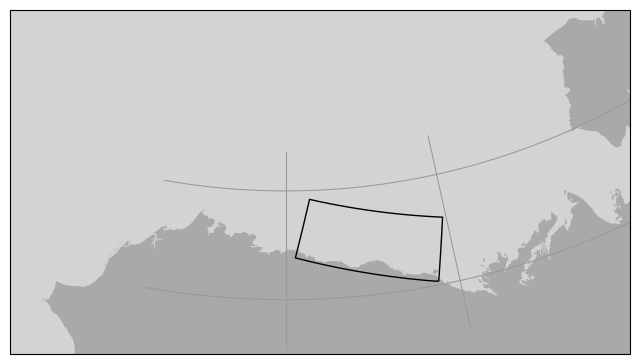

In [34]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# for key in ['era', 'ppd']:
#     ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
#                zorder=100, s = 10, transform=ccrs.PlateCarree())



line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69.25,72]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-150,-137.5]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    


### Open polynya and forcing stats

In [37]:
df = pd.read_csv('../data/compiled_stats.csv')

df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')
# df['ese10'][df.year>=2016] = 1.3*df['ese10'][df.year>=2016]




df['si_km'] = df['si'] * units('cm/s').to('km/day')

df['e10'] = - df['u10']
# manually modify this for now since I set too strict of threshold

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
    
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude




# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]



/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [16]:
cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
all_ss = list(set(dfr['sequence'][cond]))


# cond = ((dfr['sequence']!=-999))
# all_ss = list(set(dfr['sequence'][cond]))


In [17]:
dfr['time'][(dfr['sequence'] == 92)]

4444    2017-01-27
Name: time, dtype: object

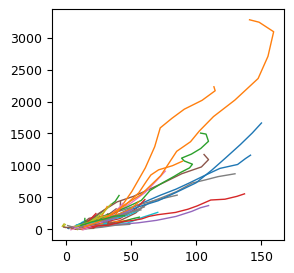

In [38]:
fig, ax = plt.subplots(figsize=(3,3))

all_cum_size = np.array([])

for ss in all_ss:
    
    ii = np.where((dfr['sequence'] == ss)&(dfr['first_day'] == True))[0][0]
    ff = np.where((dfr['sequence'] == ss)&(dfr['final_day'] == True))[0][0]
    
    
    ax.plot(np.cumsum(-dfr.u10[ii:ff+1]), np.cumsum(dfr.length_145max[ii:ff+1]))
    
    all_cum_size = np.append(all_cum_size, np.sum(dfr.extent[ii:ff+1]))
    
    
#     ax.plot(np.cumsum(dfr.u10[ii:ff+1]**2), np.cumsum(dfr.length_145max[ii:ff+1]))

In [39]:
np.sum(all_cum_size[np.argsort(all_cum_size)][-2:]) / np.sum(all_cum_size[np.argsort(all_cum_size)][:120])

2.1528421678614547

In [40]:
np.sum(all_cum_size[np.argsort(all_cum_size)][-2:]) / np.sum(all_cum_size[all_cum_size<=8775.679752440246])

1.006925348087484

In [41]:
np.sum(all_cum_size[np.argsort(all_cum_size)][-1:]) / np.sum(all_cum_size[all_cum_size<=3977.7001019800664])

1.0822593150908981

In [42]:
np.nanpercentile(all_cum_size, 80)

3650.1302324257676

In [43]:
all_cum_size[np.argsort(all_cum_size)][-2:]

array([ 71934.31946791, 102928.22815122])

In [44]:
np.sum(all_cum_size[np.argsort(all_cum_size)][:])

608861.385350461

In [45]:
np.sum(all_cum_size[np.argsort(all_cum_size)][:-6])

309531.65088898025

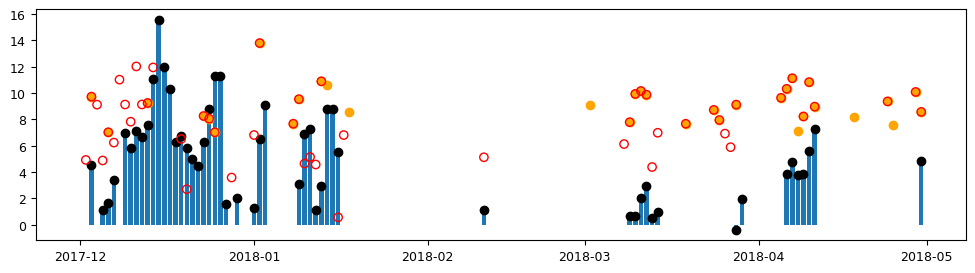

In [46]:
year = 2018

fig, ax = plt.subplots(figsize=(12,3))

ax.bar(pd.to_datetime(df.time[df.year==year]), df.length_145max[df.year==year]/10)
ax.scatter(pd.to_datetime(df.time[(df.year==year)&(df.extent>0)]), df.length_145max[(df.year==year)&(df.extent>0)]/10, c='k')

cond = (df.year==year) &(dir_conds(df, 'wind'))&(speed_conds(df, 'wind'))
ax.scatter(pd.to_datetime(df.time[cond]), df.s10[cond], c='orange')
cond = (df.year==year) &(dir_conds(df, 'ice'))&(speed_conds(df, 'ice'))
ax.scatter(pd.to_datetime(df.time[cond]), df.s10[cond], facecolor='None', edgecolor='r')
# ax.plot([pd.to_datetime(df.time[cond]),pd.to_datetime(df.time[cond])], [0,df.s10[cond]], c='r')

In [58]:

#=============
DF = dfb
#=============

not_last_day = (DF.final_day==False)
not_last_day[DF.single_day==True] = True

cond = (not_last_day&(DF.extent>0)) #& (DF.year<2016)
cond = (DF.extent>0)
# cond[DF.before_event_length==-1] = True

cond2 = (DF.extent==0) & (DF.before_event_length<-1)


# cond = (DF.extent>0)

In [59]:
print(np.sum(dir_conds(DF, 'wind')&(cond)) / np.sum(cond))
print(np.sum(dir_conds(DF, 'ice')&(cond)) / np.sum(cond))

print()

print(np.sum(speed_conds(DF, 'wind')&(dir_conds(DF, 'wind')&(cond)) )/ np.sum(cond))
print(np.sum(speed_conds(DF, 'ice')&(dir_conds(DF, 'ice')&(cond)) )/ np.sum(cond))

print()

print(np.sum((dir_conds(DF, 'wind')&(cond2)) )/ np.sum(cond2))
print(np.sum((dir_conds(DF, 'ice')&(cond2)) )/ np.sum(cond2))

print()

print(np.sum(speed_conds(DF, 'wind')&(dir_conds(DF, 'wind')&(cond2)) )/ np.sum(cond2))
print(np.sum(speed_conds(DF, 'ice')&(dir_conds(DF, 'ice')&(cond2)) )/ np.sum(cond2))

0.8061002178649237
0.7864923747276689

0.644880174291939
0.6252723311546841

0.2338227297444263
0.2669929309407287

0.08210984230560087
0.06144643828167482


In [1024]:
0.017 * 6 * units('m/s').to('km/day')

<Quantity(8.8128, 'kilometer / day')>

In [321]:
len(dfr[dfr.extent > 545])/len(list(set(dfr.year[dfr.year!=2012])))

12.409090909090908

In [325]:
len(dfr[dfr.length_145max > 100])/len(list(set(dfr.year[dfr.year!=2012])))

5.181818181818182

In [327]:
len(dfr[dfr.length_145max > 200])/len(list(set(dfr.year[dfr.year!=2012])))

1.1818181818181819

In [326]:
len(list(set(dfr[dfr.length_145max > 100].year)))/len(list(set(dfr.year[dfr.year!=2012])))

0.7272727272727273

In [328]:
len(list(set(dfr[dfr.length_145max > 200].year)))/len(list(set(dfr.year[dfr.year!=2012])))

0.22727272727272727

In [329]:
list(set(dfr[dfr.length_145max > 200].year))

[2016, 2020, 2024, 2004, 2008]

In [307]:
len(dfr[dfr.extent > 545])/len(list(set(dfr.year)))

11.869565217391305

In [306]:
len(dfr[dfr.extent > 0])/len(list(set(dfr.year)))

23.347826086956523

In [ ]:
len(dfr[dfr.extent > 0])/len(list(set(dfr.year)))

In [301]:
len(list(set(dfr.year)))

23

In [67]:
cond = (df.year==year) &(dir_conds(df, 'wind'))&(speed_conds(df, 'wind'))

In [56]:
len(df.time[(df.extent>500)&(df.extent<600)])

28

In [57]:
df.time[(df.extent>500)&(df.extent<600)]

2441    2003-12-22
2828    2006-03-16
3034    2007-12-10
3350    2009-12-23
3877    2013-03-06
3887    2013-03-16
3992    2014-01-29
4115    2015-01-01
4250    2015-12-16
4271    2016-01-06
4292    2016-01-27
4330    2016-03-05
4331    2016-03-06
4332    2016-03-07
4334    2016-03-09
4405    2016-12-19
4639    2018-03-12
4747    2019-01-28
4858    2019-12-19
5002    2020-12-11
5003    2020-12-12
5096    2021-03-15
5159    2021-12-17
5280    2022-04-17
5332    2023-01-08
5390    2023-03-07
5447    2023-12-03
5468    2023-12-24
Name: time, dtype: object

In [54]:
df.time[df.extent>500]

2269    2002-12-01
2291    2002-12-23
2292    2002-12-24
2311    2003-01-12
2319    2003-01-20
           ...    
5700    2025-03-14
5701    2025-03-15
5706    2025-03-20
5707    2025-03-21
5708    2025-03-22
Name: time, Length: 283, dtype: object

<>:132: SyntaxWarning: invalid escape sequence '\m'
<>:133: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\m'
<>:133: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_47217/779042473.py:132: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Cumulative east wind ($\mathrm{m\;s^{-1}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_47217/779042473.py:133: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Cumulative\npolynya\nextent\n($\mathrm{10^{3}\;km^2}$)', rotation=0, labelpad=30)


2 2002-12-10 00:00:00
3 2002-12-22 00:00:00
4 2003-01-10 00:00:00
5 2003-01-19 00:00:00
6 2003-01-24 00:00:00
7 2003-02-07 00:00:00
9 2003-03-04 00:00:00
10 2003-04-15 00:00:00
11 2003-12-07 00:00:00
12 2003-12-11 00:00:00
14 2003-12-29 00:00:00
15 2004-01-11 00:00:00
16 2004-01-17 00:00:00
18 2004-12-17 00:00:00
23 2006-03-15 00:00:00
26 2006-12-16 00:00:00
27 2007-01-13 00:00:00
28 2007-02-01 00:00:00
29 2007-02-07 00:00:00
30 2007-02-12 00:00:00
32 2007-04-19 00:00:00
34 2007-12-14 00:00:00
35 2007-12-24 00:00:00
37 2008-01-02 00:00:00
39 2008-02-12 00:00:00
40 2008-02-21 00:00:00
41 2008-04-23 00:00:00
42 2008-12-09 00:00:00
44 2008-12-22 00:00:00
49 2009-03-09 00:00:00
50 2009-12-22 00:00:00
51 2009-12-28 00:00:00
55 2010-12-06 00:00:00
56 2011-01-04 00:00:00
57 2012-12-22 00:00:00
58 2013-01-14 00:00:00
59 2013-03-06 00:00:00
60 2013-03-16 00:00:00
61 2013-12-30 00:00:00
63 2014-01-28 00:00:00
65 2014-02-27 00:00:00
67 2014-04-25 00:00:00
69 2014-12-21 00:00:00
70 2014-12-28 00:0

Text(0.95, 1.05, 'a')

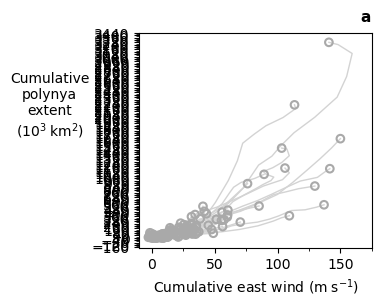

In [127]:
fig, ax = plt.subplots(figsize=(3,2.8))

import matplotlib.colors as colors
cnorm = colors.Normalize(vmin=-50, vmax=50)


all_cum_ss = np.array([])

for ss in all_ss:
    
   


    ii = np.where((dfr['sequence'] == ss)&(dfr['first_day'] == True))[0][0]
    ff = np.where((dfr['sequence'] == ss)&(dfr['final_day'] == True))[0][0]
    
    
    st = datetime(2016,11,1)
    ed = datetime(2018,5,1)

    event_time = pd.to_datetime(dfr['time'][ii:ii+1].values)
    
    if (event_time > datetime(2015,11,1)):
        fc = 'None'
        ec = 'darkgray'
    else:
        fc = 'None'
        ec = 'darkgray'
        
    if (event_time > st) & (event_time < ed):
#         print(event_time)
        zorder = 1
#         ec = 'k'
        lw = 1.5
        marker='o'

    else:
        zorder = 1
#         ec = 'k'
        lw = 1.5
        marker='o'
        

#     cond = (dfr['sequence'] == ss)&(dfr['final_day']==False)
#     cum_wind = -np.cumsum(0.02*dfr['u10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
    
#     cum_u_wind = -np.cumsum(0.02*dfr['u10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
#     cum_v_wind = np.cumsum(0.02*dfr['v10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
#     cum_wind = np.sqrt(cum_u_wind**2+cum_v_wind**2)
    
    size = 100
    
    mean_u = np.mean(dfr['u10'][ii:ff+1])
    mean_v = np.mean(dfr['v10'][ii:ff+1])
    
    
    U = -dfr['u10'][ii:ff+1]
    V = dfr['v10'][ii:ff+1]
    S = np.sqrt(U**2+V**2)#**2
    
    
    sum_u = np.sum(-dfr['u10'][ii:ff+1])
    sum_v = np.sum(dfr['v10'][ii:ff+1])
    sum_s = np.sqrt(sum_u**2+sum_v**2)
    
    
    mean_s = np.sqrt(mean_u**2+mean_v**2)
    
    lengths = dfr['length_145max'][ii:ff+1]
#     tot_ext = np.sum(dfr['extent'][ii:ff+1]) / 1000
    tot_ext = np.sum(dfr['length_145max'][ii:ff+1])
    event_duration = dfr['event_day'][ii:ff+1]
    
    cmap = cmocean.cm.balance
    edgecolor = [0.3,0.3,0.3]
#     lw = 0.5
    size = 30
    
    angle = vectors.vector_angle(mean_u, mean_v).magnitude
    
#     plt.scatter(sum_u, sum_v, c=tot_ext,  cmap=cmap,  norm = cnorm, s=size, edgecolor=edgecolor, lw=lw)

    X = np.sum(U)

    plt.plot(np.cumsum(U), np.cumsum(dfr['length_145max'][ii:ff+1]), c='lightgray', lw=1, ls='solid', zorder=-1)

    cmesh = plt.scatter(X, tot_ext, c=fc, marker=marker,  s=size, edgecolor=ec, lw=lw, zorder = zorder)


#     cmesh = plt.scatter(X, tot_ext, c=sum_v,  cmap=cmap,  norm = cnorm, s=size, edgecolor=ec, lw=lw, zorder = zorder)

    
#     if tot_ext > 25000:
#         print(dfr['time'][ii:ff])
    
    
    if tot_ext > 28:
        print(ss, event_time[0])

#     if X > 100:
#         print(ss)
    
    
    if ss ==150:
        largest = tot_ext
    all_cum_ss = np.append(all_cum_ss, tot_ext)
    if ss ==99:
        aw = tot_ext
#     else:
#         all_cum_ss = np.append(all_cum_ss, tot_ext)
#     lift = -1
#     move = 13
#     if ss == 92:  
#         plt.text(X, tot_ext+lift, "Jan\n'18'", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
#     if ss == 99:  
#         plt.text(X+move, tot_ext+lift, "Dec\n'17", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='k', marker=marker,s=size, edgecolor='None', lw=lw)
#     if ss == 150:  
#         plt.text(X+move, tot_ext+lift, "Jan\n'24", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='k',marker=marker, s=size, edgecolor='None', lw=lw)

        
# ax.set_yscale('log')
# ax.set_xscale('log')
# plotter.add_colorbar(fig, ax, [cmesh], cb_placement='top', cb_orientation='auto', cb_width='auto', 
#              cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither',
#              cb_label='Cumulative southerly wind (m/s)', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
#              tick_kwargs=None, cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])

# colors.LogNorm(vmin=data.min(), vmax=data.max())
ax.set_xlabel('Cumulative east wind ($\mathrm{m\;s^{-1}}$)')
ax.set_ylabel('Cumulative\npolynya\nextent\n($\mathrm{10^{3}\;km^2}$)', rotation=0, labelpad=30)

# ax.set_ylim(-5,120)
ax.set_xlim(-10,175)
# ax.set_xlim(-10,180)

# plt.axvline(100, c='k', ls='dashed')
# plt.plot([100,200], [50,50], c='k', ls='dashed')

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(25))

ax.yaxis.set_major_locator(ticker.MultipleLocator(40))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))
    
    
ax.text(0.95,1.05, 'a', weight='bold', size=11, transform=ax.transAxes)

# fig.savefig('../figures/results/cum_force_size.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [119]:
df.time[df.sequence==99]

4546    2017-12-09
4547    2017-12-10
4548    2017-12-11
4549    2017-12-12
4550    2017-12-13
4551    2017-12-14
4552    2017-12-15
4553    2017-12-16
4554    2017-12-17
4555    2017-12-18
4556    2017-12-19
4557    2017-12-20
4558    2017-12-21
4559    2017-12-22
4560    2017-12-23
4561    2017-12-24
4562    2017-12-25
4563    2017-12-26
4564    2017-12-27
Name: time, dtype: object

In [1261]:
largest

102.92822815121633

In [1276]:
largest/aw

3.527850249032664

In [1273]:
np.nanpercentile(all_cum_ss, 80)

3.977700101980066

In [1274]:
largest/np.sum(all_cum_ss[all_cum_ss<3.977700101980066])

1.156225690459849

In [1241]:
df.time[df['sequence'] == 85]

4361    2016-04-05
4362    2016-04-06
4363    2016-04-07
4364    2016-04-08
4365    2016-04-09
4366    2016-04-10
4367    2016-04-11
4368    2016-04-12
4369    2016-04-13
4370    2016-04-14
4371    2016-04-15
4372    2016-04-16
Name: time, dtype: object

In [1239]:
df.time[df['sequence'] == 12]

2430    2003-12-11
2431    2003-12-12
2432    2003-12-13
2433    2003-12-14
2434    2003-12-15
2435    2003-12-16
2436    2003-12-17
2437    2003-12-18
2438    2003-12-19
2439    2003-12-20
2440    2003-12-21
2441    2003-12-22
Name: time, dtype: object

In [2026]:
event_time

2278   2002-12-10
Name: time, dtype: datetime64[ns]

In [2019]:
pd.to_datetime(dfr['time'][ff])

Timestamp('2010-04-14 00:00:00')

In [2021]:
st = datetime(2016,11,1)
ed = datetime(2018,5,1)

event_time = pd.to_datetime(dfr['time'][ff])

In [2022]:
if (event_time > st) & (event_time < ed):
    print(event_time)

In [11]:
# cnorm = colors.LogNorm(vmin=0.01, vmax=10e6)
# cnorm = colors.Normalize(vmin=500, vmax=5*10e3)

In [34]:
colors = {}
colors['blue1'] = [45/255,150/255,250/255]
colors['blue2'] = [111/255,170/255,220/255]
colors['blue3'] = [0/255,129/255,243/255]

In [35]:
all_polynya_sizes = daily_data['pol']['extent'][daily_data['pol']['extent']>0]

plt.hist(all_polynya_sizes)

NameError: name 'daily_data' is not defined

## Grab stats over time by month and year

In [60]:


def plot_angles(ax, X, cond, clip):
    label_nums(ax, X, np.sum(cond), clip)
    plot_dist(ax, X-0.15, *angle_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,361,7.5), yscale=1)
    plot_dist(ax, X+0.15, *angle_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,361,7.5), yscale=1)
    
#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
        
def plot_temps(ax, X, cond, clip):
    plot_dist(ax, X, *temp_distribution(df_base, cond), clip, bins = np.arange(-40,0,2), yscale=1)

def plot_msls(ax, X, cond, clip):
    plot_dist(ax, X, *msl_distribution(df_base, cond), clip, bins = np.arange(980,1060,4), yscale=1)
    
def plot_speeds(ax, X, cond, clip):
    plot_dist(ax, X-0.15, *speed_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,20,1), yscale=1)
    plot_dist(ax, X+0.15, *speed_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,40,2), yscale=0.5)    

#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
    
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1, scale = 5, show_mode = False):
    
    h = plotter.quick_hist(y, bin_edges=bins)
    
    if show_mode == True:
        ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
    else:
        ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
        
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   
    
#     ax.barh(h['centers'], scale*h['prob'], height=h['w'], left= X - scale*h['prob']/2, align='center', 
#             color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)
    

def plot_point(ax, X, y, Y, color, bg_color):
    ax.scatter(X, Y, c=color, clip_on=False)
    ax.scatter(np.linspace(X-0.05,X+0.05, len(y)), y, c=bg_color, s=1, zorder=-1, clip_on=False)

    
def size_distribution(df, cond):

    all_sizes = df['extent'][cond]/1000
    mean_size = np.nanmean(all_sizes)
    print(mean_size)
    color = 'k'
    bg_color = 'gray'

    return all_sizes, mean_size, color, bg_color


def msl_distribution(df, cond):

    all_ = df['msl'][cond]/100
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color

def temp_distribution(df, cond):

    all_ = df['t2m'][cond]
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color


def speed_distribution(df, cond, group):
    
    if group == 'atm':
        all_speeds = df['s10'][cond]
        mean_speed = np.nanmean(all_speeds)
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        all_speeds = df['si'][cond] #* units('cm/s').to('km/day').magnitude
        mean_speed = np.nanmean(all_speeds)
        color = 'r'
        bg_color = 'lightcoral'

    return all_speeds, mean_speed, color, bg_color

def angle_distribution(df, cond, group):

    if group == 'atm':
        U = df['u10'][cond]
        V = df['v10'][cond]
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        U = df['ui'][cond]
        V = df['vi'][cond]
        color = 'r'
        bg_color = 'lightcoral'

    all_angles = np.array([vectors.vector_angle(u,v).magnitude for u,v in zip(U,V)])
    mean_angle = vectors.vector_angle(np.nanmean(U), np.nanmean(V)).magnitude
    
    if mean_angle < 0:
        mean_angle+=360
    all_angles[all_angles<0] += 360

    return all_angles, mean_angle, color, bg_color

def label_nums(ax, x, N, clip):
    ax.text(x, -10, N, ha='center',va='bottom', size=5, clip_on=clip)
    
    


### Identify which days to include for each event

<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:151: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/112229227.py:151: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')


13
135


Text(9.75, 207, 'After')

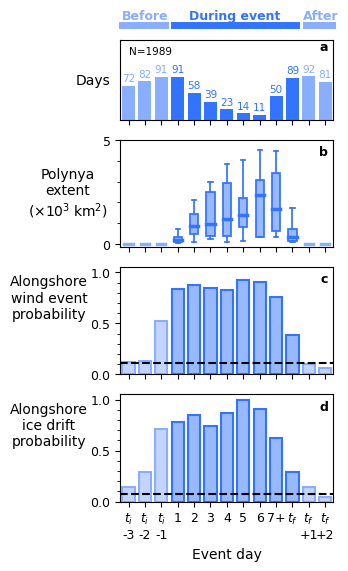

In [62]:
fig, axs = plt.subplots(4,1,figsize=(2.75,6), gridspec_kw={'height_ratios':[0.75,1,1,1]})


#=============
L = 6
#=============


#=============
DF = dfb
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


comp_ = (DF.extent==0)
comp_[(DF.day_before_event>=-3)]=False
comp_[(DF.day_after_event<=2)&(DF.day_after_event>-999)]=False

def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    
days_before = np.array([-4,-3,-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [(DF['day_before_event'] == dd)&(DF['before_event_length']>1) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)


days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]

# conds_more = [((df['final_day'] == True)&(df['first_day']==False))]

day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(shoulder==False))&(DF['single_day']==False)]   

days_after = np.array([1,2,3])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [(DF['day_after_event'] == dd)&(DF['after_event_length']>1) for dd in days_after]   


x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))

    
    
color1 = [50/255,115/255, 255/255]   
color2 = [137/255,173/255, 255/255]   
    
    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,170)
ax.set_yticks([])
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
for dd, cond in zip(x_values[1:-1], all_cond[1:-1]):
    
    if (dd >0)&(dd < 9):
        ax.bar(dd, np.sum(cond), color=color1)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color1, va='bottom', ha='center', size=7.5)
    else:
        ax.bar(dd, np.sum(cond), color=color2)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color2, va='bottom', ha='center', size=7.5)
ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='k', size = 7.5,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-0.75+1.25, x_values.max()+0.75-1.25)
    ax.set_xticks(x_values[1:-1])
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels[1:-1]);
# plt.xticks(fontsize=9)



for ax in axs[2:]:
    ax.set_ylim(0,1.05)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


axs[2].set_ylabel('Alongshore\nwind event\nprobability', rotation=0, labelpad=30)
axs[3].set_ylabel('Alongshore\nice drift\nprobability', rotation=0, labelpad=30)

ax = axs[2]

for ax, cat in zip(axs[2:], ['wind', 'ice']):
    
    wind_prob = np.array([])
    for dd, cond in zip(x_values, all_cond):
        cond1 = cond & (dir_conds(DF, cat))& speed_conds(DF, cat)
        wind_prob = np.append(wind_prob, np.sum(cond1)/np.sum(cond))
        
    width = 0.75    
        
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,color = color1, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    
    
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,facecolor='None', edgecolor = color1, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    
#     ax.plot(x_values, wind_prob, color = 'k', ls='solid', marker='s', alpha=1, zorder=1)

    cond = comp_
    cond1 = cond & (dir_conds(DF, cat)&speed_conds(DF, cat))
    ax.axhline(np.sum(cond1)/np.sum(cond), ls='dashed', lw=1.5,  c = 'k', zorder=2)




    
axs[-1].set_xlabel('Event day')

for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 0.99, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    else:
        ax.text(0.975, 0.95, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    
C = 'k'

ax = axs[1]
ax.set_ylim(-0.15,5)
ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')
VAR = 'extent'
for dd, cond in zip(x_values, all_cond):
    
    bf=0.25
    
    if (dd >= 1)&(dd<9):
        color = color1
    else:
        color = color2
        
#     ax.scatter(np.linspace(dd-bf,dd+bf, np.sum(cond)), DF[VAR][cond]/10e2,
#                c=color, s=5, zorder=1)
    
    LW = 1.25
    
    bottom = np.nanpercentile(DF[VAR][cond], 25)/10e2
    middle = np.nanpercentile(DF[VAR][cond], 50)/10e2
    top = np.nanpercentile(DF[VAR][cond], 75)/10e2
    high = np.nanpercentile(DF[VAR][cond], 90)/10e2
    low = np.nanpercentile(DF[VAR][cond], 10)/10e2
    height=(top-bottom)
    rectangle = patches.Rectangle((dd-bf, bottom), 2*bf, height, lw=LW, edgecolor='None', facecolor=color, alpha=0.5)
    ax.add_patch(rectangle)
    rectangle = patches.Rectangle((dd-bf, bottom), 2*bf, height, lw=LW, edgecolor=color, facecolor='None')
    ax.add_patch(rectangle)
#     ax.plot(rectangle)
    
    ax.plot([dd-bf,dd+bf],[middle, middle], c = color, lw=2*LW, zorder=1)
    ax.plot([dd,dd],[top, high], c = color, lw=LW, zorder=1)
    ax.plot([dd,dd],[low, bottom], c = color, lw=LW, zorder=1)
    
    bb = bf/2
    ax.plot([dd-bb,dd+bb],[high, high], c = color, lw=LW, zorder=1)
    ax.plot([dd-bb,dd+bb],[low, low], c = color, lw=LW, zorder=1)
    
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25)/10e2,
#             np.nanpercentile(DF[VAR][cond], 75)/10e2], c=color, zorder=1)
    
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 10)/10e2,
#             np.nanpercentile(DF[VAR][cond], 90)/10e2], c=color, zorder=1)

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    
# Get the y-axis tick labels
xtick_labels = axs[-1].get_xticklabels()

# Change the color of specific y-axis tick labels
# for i, label in enumerate(xtick_labels):
#     if (i >=3)&(i<11):  # Change every other y-axis label to green
#         label.set_color(color1)
#     else:
#         label.set_color(color2)

        
ax = axs[0]

yy = 200
ax.plot([0.8,8.2], [yy,yy], c=color1, lw=5, clip_on=False)
ax.text(4.5,yy+7, 'During event', weight='bold', c=color1, va='bottom', ha='center', clip_on=False)
ax.plot([-2.4,0.2], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(-1,yy+7, 'Before', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)
ax.plot([8.8,10.4], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(9.75,yy+7, 'After', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)
# fig.savefig('../figures/results/comp_time.png', dpi=400, bbox_inches='tight')

<>:112: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:147: SyntaxWarning: invalid escape sequence '\m'
<>:202: SyntaxWarning: invalid escape sequence '\m'
<>:112: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:147: SyntaxWarning: invalid escape sequence '\m'
<>:202: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48178/505133768.py:112: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48178/505133768.py:127: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Wind speed\n($\mathrm{m\;s^{-1}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48178/505133768.py:147: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Ice speed\n($\mathrm{km\;d^{-1}}$)')
/var/folders/p8/hz449fpx6nsc

13
133


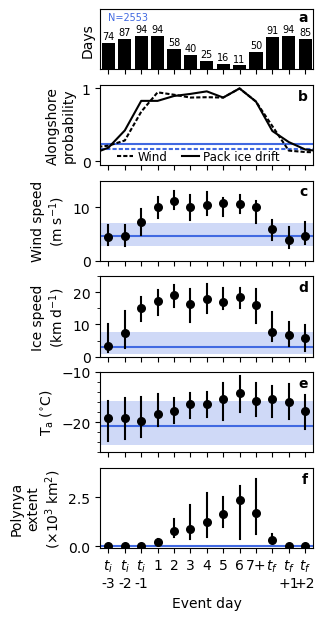

In [538]:
fig, axs = plt.subplots(6,1,figsize=(2.75,7), gridspec_kw={'height_ratios':[0.75,1,1,1,1,1]})


#=============
L = 6
#=============

var = 't2m'

#=============
DF = dfb
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


comp_ = (DF.extent==0)

def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    
    
days_before = np.array([-4,-3,-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [(DF['day_before_event'] == dd)&(DF['before_event_length']>1) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)


days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]

# conds_more = [((df['final_day'] == True)&(df['first_day']==False))]

day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(shoulder==False))&(DF['single_day']==False)]   

days_after = np.array([1,2,3])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [(DF['day_after_event'] == dd)&(DF['after_event_length']>1) for dd in days_after]   


x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))






    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,170)
ax.set_yticks([])
ax.set_ylabel('Days')
for dd, cond in zip(x_values[1:-1], all_cond[1:-1]):
    ax.bar(dd, np.sum(cond), color='k')
    ax.text(dd, np.sum(cond)+5, np.sum(cond), 
            color='k', va='bottom', ha='center', size=7)
ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='royalblue', size = 7,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-0.75+1.25, x_values.max()+0.75-1.25)
    ax.set_xticks(x_values[1:-1])
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels[1:-1]);
# plt.xticks(fontsize=9)

# for dd, cond in zip(x_values, all_cond):
#     angles = np.copy(df['a10'][cond])
#     angles[angles<0]+=360
#     angle_of_mean = vectors.vector_angle(np.nanmean(df['u10'][cond]), np.nanmean(df['v10'][cond])).magnitude
#     if angle_of_mean < 0:
#         angle_of_mean+=360
#     plot_dist(ax, dd, angles, angle_of_mean, 
#           'r', 'lightcoral', False, bins = np.arange(0, 361,10), yscale = 1, scale=3, show_mode=False)
    
# for dd, cond in zip(x_values, all_cond):
#     angles = np.copy(df['ai'][cond])
#     angles[angles<0]+=360
#     angle_of_mean = vectors.vector_angle(np.nanmean(df['ui'][cond]), np.nanmean(df['vi'][cond])).magnitude
#     if angle_of_mean < 0:
#         angle_of_mean+=360
#     plot_dist(ax, dd, angles, angle_of_mean, 
#           'b', 'dodgerblue', False, bins = np.arange(0, 361,10), yscale = 1, scale=3)


# plt.axhline(165, c='k', ls='dashed', zorder=-1)

C = 'k'

ax = axs[5]
ax.set_ylim(-0.1,4)
ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)')
VAR = 'extent'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50)/10e2, facecolor = 'k', edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5)/10e2,
#             np.nanpercentile(DF[VAR][cond], 95)/10e2], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25)/10e2,
            np.nanpercentile(DF[VAR][cond], 75)/10e2], c=C, zorder=1)
ax.axhline(0, c='royalblue', zorder=-1)
    
    
C = 'k'

ax = axs[2]
ax.set_ylim(0,15)
ax.set_ylabel('Wind speed\n($\mathrm{m\;s^{-1}}$)')
VAR = 's10'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)
# ax.axhline(7, c='gray', ls='dotted', zorder=1)
# ax.text(7.35, 7.5, '$\mathrm{7\;m\;s^{-1}}$', c='gray',size = 9.5, zorder=0)

ax = axs[3]
ax.set_ylim(0,25)
ax.set_ylabel('Ice speed\n($\mathrm{km\;d^{-1}}$)')
VAR = 'si_km'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)

# ax.axhline(10, c='gray', ls='dotted', zorder=0)
# ax.text(3, 5.25, '$\mathrm{10\;km\;d^{-1}}$', c='gray', size = 9.5,zorder=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))

ax = axs[1]
ax.set_ylabel('Alongshore\nprobability')
ax.set_ylim(-0.05,1.05)
ax.plot([-1.5,-0.5],[.075,.075], c='k', ls='dashed', dashes=(2, 1), zorder=1)
ax.plot([2.5,3.5],[.075,.075], c='k', ls='solid', zorder=1)
ax.text(-0.25, 0.15, 'Wind', size = 8.5, va = 'top', ha='left', c='k', zorder=0)
ax.text(3.75, 0.15, 'Pack ice drift', size = 8.5,va = 'top', ha='left',  c='k', zorder=0)


ice_prob = np.array([])
wind_prob = np.array([])
for dd, cond in zip(x_values, all_cond):
    
    cond1 = cond & (dir_conds(DF, 'ice')&speed_conds(DF, 'ice'))
    cond2 = cond & (dir_conds(DF, 'wind')&speed_conds(DF, 'wind'))
    
    ice_prob = np.append(ice_prob, np.sum(cond1)/np.sum(cond))
    wind_prob = np.append(wind_prob, np.sum(cond2)/np.sum(cond))
    
ax.plot(x_values, ice_prob, color = 'k', alpha=1, zorder=1)
ax.plot(x_values, wind_prob, color = 'k', ls='dashed', dashes=(2, 1), alpha=1, zorder=1)

    
cond = comp_
cond1 = cond & (dir_conds(DF, 'ice')&speed_conds(DF, 'ice'))
cond2 = cond & (dir_conds(DF, 'wind')&speed_conds(DF, 'wind'))
ax.axhline(np.sum(cond2)/np.sum(cond), c = 'royalblue', zorder=-2)
ax.axhline(np.sum(cond1)/np.sum(cond), c = 'royalblue', ls='dashed',dashes=(2, 1), zorder=-2)



    
ax = axs[4]
ax.set_ylim(-26,-10)
ax.set_ylabel('$\mathrm{T_{a}\;(^{\circ}C}$)')
VAR = 't2m'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    
    
    
    
axs[-1].set_xlabel('Event day')
#     plot_dist(ax, dd, df['t2m'][cond], np.nanmean(df['t2m'][cond]), 
#           'r', 'lightcoral', True, bins = np.arange(-36,4,2), yscale = 1)
    
    
# ax = axs[4]
# ax.set_ylim(-500,10000)
# for dd, cond in zip(x_values, all_cond):
#     ax.axhline(np.nanmean(df['extent'][df.extent==0]), c='r', zorder=-1)
#     plot_dist(ax, dd, df['extent'][cond], np.nanmean(df['extent'][cond]), 
#           'r', 'lightcoral', True, bins = np.arange(0,25000,500), yscale = 1)


for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 0.99, f'{chr(97+aa)}', ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    else:
        ax.text(0.975, 0.95, f'{chr(97+aa)}', ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    
# plt.ylim(-10,300)
#     plt.scatter(dd, np.nanmean(df['esei'][(df['event_day'] == dd)&(shoulder==False)]), color = 'k')


# fig.savefig('../figures/results/comp_time_v4.png', dpi=400, bbox_inches='tight')

In [539]:

#=============
DF = dfb
#=============

# not_last_day = (DF.final_day == False)
# not_last_day[DF.single_day == True] == True

not_last_day = (DF.final_day == False)
not_last_day[DF.single_day == True] = True

print(np.nanpercentile(DF.si_km[((DF.extent > 0)&(not_last_day))+(DF.day_before_event==-1)], 25))
print(np.nanpercentile(DF.s10[((DF.extent > 0)&(not_last_day))+(DF.day_before_event==-1)], 25))

# print(np.nanpercentile(DF.si_km[((DF.extent > 0)&(not_last_day))], 25))
# print(np.nanpercentile(DF.s10[((DF.extent > 0)&(not_last_day))], 25))



10.97569646345195
6.508233014464062


In [540]:
np.nanpercentile(DF.s10[DF.extent == 0], 85)

8.368934065296683

In [541]:
cond = (DF.extent==0)
cond1 = cond & (dir_conds(DF, 'wind') & speed_conds(DF, 'wind'))
cond2 = cond & (dir_conds(DF, 'wind'))
# ax.axhline(dd,np.sum(cond2)/np.sum(cond), color = 'royalblue', alpha=0.2,  zorder=1)
# ax.axhline(dd,np.sum(cond1)/np.sum(cond), color = 'royalblue', zorder=1)

In [1903]:
dir_conds(DF, 'wind') & speed_conds(DF, 'wind')

2269    False
2270    False
2271    False
2272     True
2273    False
        ...  
5440    False
5441    False
5442    False
5443    False
5444     True
Length: 3176, dtype: bool

In [108]:
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1):
    h = plotter.quick_hist(y, bin_edges=bins)
    
    ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    scale = 5
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   

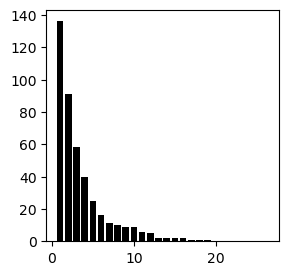

In [124]:
fig, ax = plt.subplots(figsize=(3,3))

# plt.ylim(-1,170)


all_ese = []
all_ese_std = []
all_ese75 = []
all_ese25 = []
all_ff = []

for L in range(1,27):
    num_events = np.sum((df['event_day'] == L)&(shoulder==False))
    ax.bar(L, num_events, color='k')

In [124]:
14*units('cm/s').to('km/day')

# 15*units('km/day').to('cm/s')

<Quantity(12.096, 'kilometer / day')>

In [71]:
wind_durations = []
ice_durations = []
pol_durations = []

for year in years:

    df_year = df[df.year==year]
    wind_dates = pd.to_datetime(df_year.time[wind_cond(df_year)].values)
    wind_seqs = tseries.dates_to_sequences(wind_dates, dt_max=1*units('day'))

    for ss in wind_seqs:
        
        wind_durations.append(len(wind_seqs[ss]))
         
    ice_dates = pd.to_datetime(df_year.time[ice_cond(df_year)].values)
    ice_seqs = tseries.dates_to_sequences(ice_dates, dt_max=1*units('day'))

    for ss in ice_seqs:
        
        ice_durations.append(len(ice_seqs[ss]))
        
    pol_dates = pd.to_datetime(df_year.time[df_year.extent>0].values)
    pol_seqs = tseries.dates_to_sequences(pol_dates, dt_max=1*units('day'))

    for ss in pol_seqs:
        
        pol_durations.append(len(pol_seqs[ss]))
        

In [677]:
wind_seqs

{}

In [119]:
0.286*0.286

0.08179599999999998

In [ ]:
0.286*0.286

In [106]:
11.574074074/2

5.787037037

In [92]:
10 * units('km/day').to('cm/s')

<Quantity(11.5740741, 'centimeter / second')>

In [89]:
15 * units('cm/s').to('km/day')

<Quantity(12.96, 'kilometer / day')>

<BarContainer object of 22 artists>

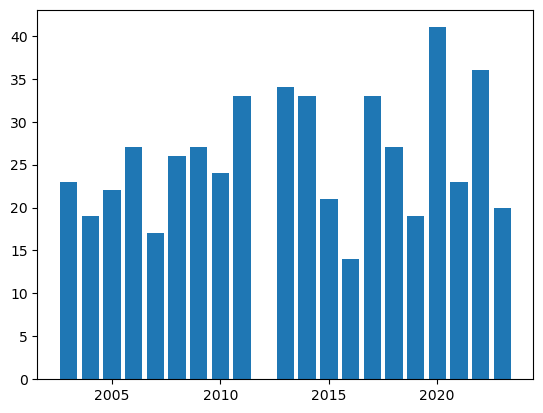

In [69]:
plt.bar(yearss[time_cond], per50_wf_numconsidered[time_cond])

a10_r 272.5
a10_r
[245 250 255 260 265 270 275 280 285 290 295 300 305]
0.9287671232876712
ai_r 287.5
ai_r
[260 265 270 275 280 285 290 295 300 305 310 315 320]
0.926027397260274
centermass_direction_r 307.5
centermass_direction_r
[ 15 280 285 290 295 300 305 310 315 320 325 355]
0.9531680440771348


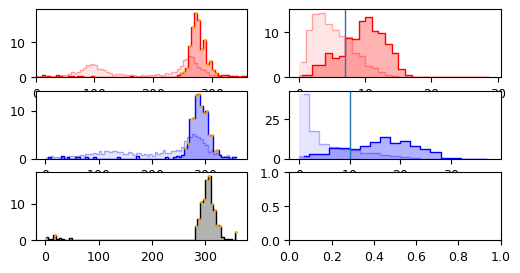

In [431]:

# create plot
fig, AXS = plt.subplots(3,2, figsize=(6,3), subplot_kw={'projection': None})


#============
# DF = df[(df.year>=1987)&(df.year<2026)]
DF = dfb
# DF = df[(df.year>=2016)&(df.year<2024)]
# DF = df[(df.year>=2003)&(df.year<2016)]
#============

ccolor = 'blue'
bcolor = 'red'

not_final_day = (DF.final_day == False)
not_final_day[DF.first_day==True] = True

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
# comp_ = (DF.extent>0)
open_ = (DF.extent>0)&(not_final_day)
# open_strict = (DF.extent>0)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)


axs = AXS.ravel()

for ax, group, color in zip([axs[0], axs[2], axs[4]], 
                            ['a10_r', 'ai_r', 'centermass_direction_r'],
                            [bcolor, ccolor, 'k']):
    
#     x = DF[f'a{group}'][comp_]
#     x[x<0]+=360
#     h = plotter.quick_hist(x, bin_edges = bins)


    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.3, color=color, zorder=-1)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=-1)

    
    print(group, h2['centers'][np.argmax(h2['prob'])] )
    
    if group != 'centermass_direction_r':
        x = DF[f'{group}'][comp_]
        h = plotter.quick_hist(x, bin_edges = bins)

        theta = h['centers']
        width = h['w']
        ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
        ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)

    # Plot bars
#     theta = h['centers']
#     width = h['w']
#     ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.6, color=ccolor, zorder=0)
#     ax.step(theta, 100*h['prob'], where='mid', alpha=1, color=ccolor,lw=1, zorder=0)
    
    print(group)
#     ax.axvline((90-165)+360, c='k', ls='dashed')
#     ax.axvline((90-165-180)+360, c='k', ls='dashed')
    
    
    
#     COND = (h2['prob']>1.25*h['prob'])&(h2['prob']>0.01)
#     print(h2['edges'][:-1][COND])
#     print(np.sum(h2['prob'][COND]))
#     print(h2['centers'][np.argmax(h2['prob'])])
    
    COND = (h2['prob']>0.01)
    print(h2['edges'][:-1][COND])
    print(np.sum(h2['prob'][COND]))
    
    ax.scatter(h2['centers'][COND], 100*h2['prob'][COND], s=1, c='orange')
    
#     ax.set_ylim(0,20)
    
#     ax.set_xlim(0,360)

    
ax = axs[0]
# ax.axvline((90-165)+360, c='k', ls='dashed')

ax.set_xlim(0,360)


for ax, group, color, bins in zip([axs[1], axs[3]], 
                            ['s10', 'si_km',],
                            [bcolor, ccolor], [np.arange(0,30,1), np.arange(0,40,2)]):
    
    
    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.3, color=color, zorder=-1)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=-1)
    
    x = DF[f'{group}'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    theta = h['centers']
    width = h['w']
    ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
    ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)
    
ax = axs[1]
ax.axvline(7)

ax = axs[3]
ax.axvline(10)

In [461]:
# define speed and direction conditions
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
#         dir_cond = (dff['a10_r'] > 245) & (dff['a10_r'] < 310)
        
    elif cat == 'ice':
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
#         dir_cond = (dff['ai_r'] > 260) & (dff['ai_r'] < 320)
        
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 7)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 10.5)
    return speed_cond



In [463]:
open_ = DF.extent>0
comp_ = DF.extent==0

np.sum(dir_conds(DF, 'wind')&open_) / np.sum(open_)

# np.sum(dir_conds(DF, 'ice')&open_) / np.sum(open_)

0.8061002178649237

10
260
270
280
290
300
310
320


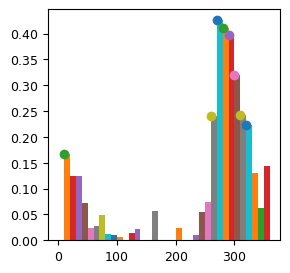

In [464]:
fig, ax = plt.subplots(figsize=(3,3))

bins = np.arange(0,361,10)

not_final_day = (DF.final_day == False)
not_final_day[DF.first_day==True] = True

#===========
DF = dfb
#===========

var = 'a10_r'
# var = 'ai_r'

tot = 0
for bb in range(len(bins)-1):
    
    bbmin = bins[bb]
    bbmax = bins[bb+1]
    dbb = np.diff(bins)[0]
    bbmid = bbmin + dbb/2
    
#     within_range = ((DF[var] >= bbmin) & (DF[var] < bbmax)) & (DF['s10']>6.5)
    within_range = ((DF[var] >= bbmin) & (DF[var] < bbmax))# & (DF['si_km']>11.5)
    
#     frac = np.sum((DF.extent[within_range]>0)&(not_final_day[within_range]))/np.sum(within_range)
    frac = np.sum((DF.extent[within_range]>0))/np.sum(within_range)
    
    plt.bar(bbmin, frac, width = dbb, align='edge')
    
    if frac > 0.15:
        ax.scatter(bbmin, frac)
        print(bbmin)
        tot+=frac

In [465]:
WITHIN = ((DF['a10_r'] > 260) & (DF['a10_r'] < 305))# & (DF['s10']>6.5)
np.sum(DF.extent[WITHIN]>0)/np.sum(DF.extent>0)

0.8061002178649237

In [466]:
WITHIN = (DF['ai_r'] > 270) & (DF['ai_r'] < 315) #& (DF['si_km']>11.5)
np.sum(DF.extent[WITHIN]>0)/np.sum(DF.extent>0)

0.7864923747276689

In [467]:
WITHIN = ((DF['a10_r'] > 260) & (DF['a10_r'] < 305)) & (DF['s10']>6.5)
np.sum(WITHIN&(DF.extent>0))/np.sum(WITHIN)

0.4835164835164835

In [468]:
WITHIN = ((DF['ai_r'] > 270) & (DF['ai_r'] < 315)) & (DF['si_km']>11.5)
np.sum(WITHIN&(DF.extent>0))/np.sum(WITHIN)

0.5063752276867031

In [469]:
325-290

35

In [470]:
[f'{tick:.0f}%' for tick in ax.get_yticks()]

['0%', '0%', '0%', '0%', '0%', '0%', '0%', '0%', '0%', '0%']

In [471]:
[f'{tick:.0f}%' for tick in ax.get_yticks()]

['0%', '0%', '0%', '0%', '0%', '0%', '0%', '0%', '0%', '0%']

<>:142: SyntaxWarning: invalid escape sequence '\m'
<>:158: SyntaxWarning: invalid escape sequence '\m'
<>:230: SyntaxWarning: invalid escape sequence '\m'
<>:231: SyntaxWarning: invalid escape sequence '\m'
<>:142: SyntaxWarning: invalid escape sequence '\m'
<>:158: SyntaxWarning: invalid escape sequence '\m'
<>:230: SyntaxWarning: invalid escape sequence '\m'
<>:231: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/2884807664.py:142: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Speed of\neasterly\nwind\n($\mathrm{m\;s^{-1}}$)', c=wind_color, rotation=0, labelpad=30, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/2884807664.py:158: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Speed of\nalongshore\nice drift\n($\mathrm{km\;d^{-1}}$)', c=ice_color, rotation=0, labelpad=35, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/2884807664.py:23

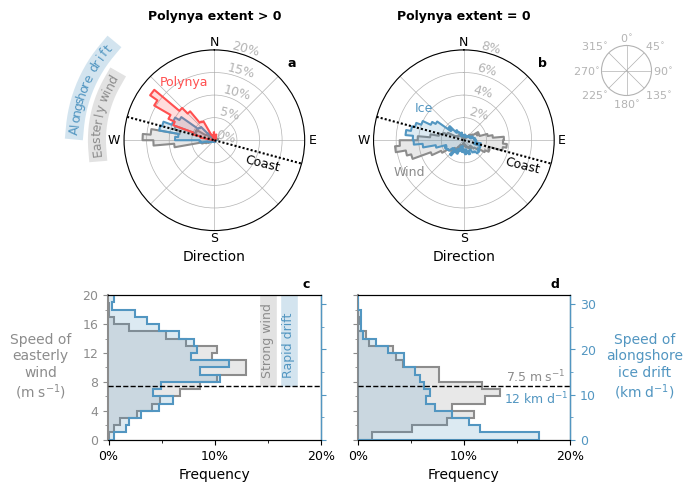

In [745]:

# create plot
fig, AXS = plt.subplots(2,2, figsize=(7,5), 
                        subplot_kw={'projection': None}, gridspec_kw={'height_ratios':[1.25,1]})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
axs[0] = fig.add_subplot(2,2, 1, projection='polar')
axs[1] = fig.add_subplot(2,2, 2, projection='polar')


grid_color = [0.7,0.7,0.7]

for ax in axs[:2]:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(zorder=-1)
    ax.set_xticklabels(['N','','E','','S','','W ']);
    ax.grid(color=grid_color)
    ax.tick_params(axis='x', pad=-5)
    
#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)  #& (DF.day_before_event!=-1)
open_ = (DF.extent>0)

#============
# ice_color = [25/255,135/255,255/255]#'royalblue'
ice_color = cmocean.cm.ice(0.6)#[0.19607843137254902, 0.45098039215686275, 1.0]
# wind_color = 'r'
# wind_color = [255/255,135/255,0/255] # orange
# wind_color = [255/255,80/255,80/255]
wind_color = [0.55]*3

poly_color = [255/255,80/255,80/255]
# poly_color = 'orange'
#============


# open direction
#----------------------
for ax, group, cond, color, scale in zip([axs[0], axs[0], axs[0]], 
                            ['a10_r', 'ai_r', 'centermass_direction_r'], [open_ , open_, open_], 
                            [wind_color, ice_color, poly_color], [1,1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1.5, zorder=3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    
# closed direction
#----------------------
for ax, group, cond, color, scale in zip([axs[1], axs[1]], 
                            ['a10_r', 'ai_r', ], [comp_ , comp_,], 
                            [wind_color, ice_color,], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1.5, zorder=3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))      
    
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,8)
axs[1].set_yticks([2,4,6,8])
for ax in axs[:2]:
    ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()])
#     ax.set_yticklabels([f'{tick:.0f}%' if tt%2==1 else '' for tt, tick in enumerate(ax.get_yticks())])
    ax.tick_params(axis='y', labelrotation=-15, colors=grid_color, pad=5)
    ax.set_rlabel_position(10)

for ax, R in zip([axs[0], axs[1]], [15,7,]):
    th = (90+15)*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed',dashes=(1,1), lw=1.5, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed',dashes=(1,1), lw=1.5, zorder=100)
    ax.text((90+15-4)*np.pi/180, R, 'Coast', rotation = -14, va='top', ha='right')

    
# SPEED BINS
#_________________

bins = np.arange(0,20,1)
for ax, group, cond, color in zip([axs[2], axs[3], ], 
                            ['s10', 's10',], 
                                  [open_&dir_conds(DF, 'wind'), comp_&dir_conds(DF, 'wind')], 
#                                   [open_, comp_],
                            [wind_color,wind_color, ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.barh(theta, 100*h2['prob'], height=width, left=0.0, alpha=0.2, color=color, zorder=-100)
    ax.stairs(100*h2['prob'], edges=h2['edges'],orientation='horizontal', alpha=1, color=color,lw=1.5, zorder=-100)



bins = np.arange(0,35,1.6)
ax2 = axs[2].twinx()
ax3 = axs[3].twinx()
for ax, group, cond, color in zip([ax2, ax3, ], 
                            ['si_km', 'si_km',], 
                                  [open_&dir_conds(DF, 'ice'), comp_&dir_conds(DF, 'ice')], 
#                                   [open_, comp_], 
                            [ice_color, ice_color, ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.barh(theta, 100*h2['prob'], height=width, left=0.0, alpha=0.2, color=color, zorder=-100)
    ax.stairs(100*h2['prob'], edges=h2['edges'], orientation='horizontal', alpha=1, color=color,lw=1.5, zorder=-100)



for ax in axs[2:]:
#     ax.set_ylim(0,18.14)
    ax.set_ylim(0,20)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.spines['left'].set_color(wind_color)
    ax.spines['left'].set_linewidth(1.5)
    ax.tick_params(axis='y', which='both', color=wind_color, labelcolor=wind_color)
    
    
ax = axs[2]
ax.set_ylabel('Speed of\neasterly\nwind\n($\mathrm{m\;s^{-1}}$)', c=wind_color, rotation=0, labelpad=30, va='center')
ax = axs[3]
ax.set_yticklabels([])


for ax in [ax2,ax3]:
    ax.set_ylim(0,32)
    ax.yaxis.tick_right()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.spines['right'].set_color(ice_color)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('None')
    ax.tick_params(axis='y', which='both', color=ice_color, labelcolor=ice_color)
    
ax = ax3
ax.set_ylabel('Speed of\nalongshore\nice drift\n($\mathrm{km\;d^{-1}}$)', c=ice_color, rotation=0, labelpad=35, va='center')
ax = ax2
ax.set_yticklabels([])
    
    
    
axs[2].set_xlim(-0.05,20)   
axs[3].set_xlim(-0.05,20)   
for ax in axs[2:]:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xlabel('Frequency')
    ax.set_xticklabels([f'{tick:.0f}%' for tick in ax.get_xticks()])

axs[0].text(0.5, 1.15, 'Polynya extent > 0', weight='bold', ha='center', va='bottom', transform=axs[0].transAxes)
axs[1].text(0.5, 1.15, 'Polynya extent = 0', weight='bold', ha='center', va='bottom', transform=axs[1].transAxes)

axs[0].text(np.pi/4, 23, 'a', weight='bold', clip_on=False)
axs[1].text(np.pi/4, 9.25, 'b', weight='bold', clip_on=False)

axs[2].text(0.95, 1.05, 'c', weight='bold', ha='right', clip_on=False, transform=axs[2].transAxes)
axs[3].text(0.95, 1.05, 'd', weight='bold', ha='right', clip_on=False, transform=axs[3].transAxes)

buffer = 4 # shorten because line too wide

ax = axs[0]
th1 = (270+buffer)*np.pi/180
th2 = (315-buffer)*np.pi/180
ax.plot(np.linspace(th1,th2,15), np.full(15,31), alpha=0.25, c=ice_color, ls='solid', lw=13, clip_on=False, zorder=-1000)
# ax.text((285)*np.pi/180, 29, '78%', c=ice_color, rotation = 70, va='bottom')

# Position each character along the arc
text = 'Alongshore drift'
theta = np.linspace(th1,th2,len(text))
for i, (char, angle) in enumerate(zip(text, theta)):
    ax.text(angle, 31, char, rotation=np.degrees(-angle), 
            c=ice_color, size=mpl.rcParams['font.size'],
            ha='center', va='center')
    

th1 = (260+buffer)*np.pi/180
th2 = (305-buffer)*np.pi/180
ax.plot(np.linspace(th1,th2,15), np.full(15,26), alpha=0.25, c=wind_color, ls='solid', lw=13, clip_on=False, zorder=-1000)
# ax.text((280)*np.pi/180, 24.5, 'Easterly wind', c=wind_color, rotation = 70, va='bottom')
# Position each character along the arc
text = 'Easterly wind'
theta = np.linspace(th1,th2,len(text))
for i, (char, angle) in enumerate(zip(text, theta)):
    ax.text(angle, 26, char, rotation=np.degrees(-angle), 
            c=wind_color, size=mpl.rcParams['font.size'],
            ha='center', va='center')
    
    
ax.set_xlabel('Direction') 
ax = axs[1]
ax.set_xlabel('Direction') 

#     ax.axhline(6.5,c=ice_color, ls='dashed', dashes=(5,5))
    
# ax = axs[3]
# ax.text(25, 7.25, '$\mathrm{6.5\;m\;s^{-1}}$', c=wind_color, ha='center');
# ax.text(25, 4.25, '$\mathrm{10\;km\;d^{-1}}$', c=ice_color, ha='center');
    
    
axs[1].text(243*np.pi/180, 7, 'Wind', c=wind_color)
axs[1].text(300*np.pi/180, 5, 'Ice', c=ice_color)
axs[0].text(315*np.pi/180, 17., 'Polynya', c=poly_color)


for ax in [ax2, ax3]:
    ax.axhline(12, c='k', ls='dashed', zorder=100)
ax = axs[3]
ax.text(16.75, 7.6, '$\mathrm{7.5\;m\;{s}^{-1}}$', c=wind_color, rotation = 0, va='bottom', ha='center')
ax.text(16.75, 6.8, '$\mathrm{12\;km\;{d}^{-1}}$', c=ice_color, rotation = 0, va='top', ha='center')

ax = axs[2]
ax.plot([15,15],[8.5,30], alpha=0.25, c=wind_color, ls='solid', lw=12,)
ax.text(15, 8.5, 'Strong wind', c=wind_color, rotation = 90, va='bottom', ha='center')

ax.plot([17,17],[8.5,30], alpha=0.25, c=ice_color, ls='solid', lw=12,)
ax.text(17, 8.5, 'Rapid drift', c=ice_color, rotation = 90, va='bottom', ha='center')

# ax.plot([17.25,17.25],[7.1,30], alpha=0.25, c=wind_color, ls='solid', lw=12,)
# ax.text(17.25, 11, '76%', c=wind_color,rotation = 90, va='bottom', ha='center')


ax = axs[3]
# ax.plot([30,30],[7.1,30], alpha=0.25, c=ice_color, ls='solid', lw=12,)
# ax.text(30, 11, '19%', c=ice_color, rotation = 90, va='bottom', ha='center')
# ax.plot([37,37],[7.1,30], alpha=0.25, c=wind_color, ls='solid', lw=12,)
# ax.text(37, 11, '35%', c=wind_color,rotation = 90, va='bottom', ha='center')


# Add inset manually: [left, bottom, width, height] in 0-1 relative figure coordinates
inset_ax = fig.add_axes([0.85, 0.8, 0.1, 0.1
                        ], projection='polar')
inset_ax.set_theta_zero_location("N")
inset_ax.set_theta_direction(-1)

# Custom theta tick positions (in degrees)
angles = [0, 45,90,135,180,225, 270,315]
# labels = ['$\\mathrm{0^{\\circ}}$', '$\\mathrm{45^{\\circ}}$','$\\mathrm{90^{\\circ}}$','$\\mathrm{135^{\\circ}}$',
#           '$\\mathrm{180^{\\circ}}$', '$\\mathrm{270^{\\circ}}$']

labels = [f'{a}'+'$\\mathrm{^{\\circ}}$' for a in angles]

# Slightly outside the border


# Add labels manually
for angle, label, ha, va, mult in zip(angles, labels, 
                            ['center','left', 'left','left', 'center', 'right', 'right', 'right'], 
                           ['bottom','bottom', 'center', 'top', 'top','top',  'center', 'bottom'],
                                     [1.05,1.03,1.05,1.05,1.1,1.05,1.05,1.03]):
    theta_rad = np.deg2rad(angle)
    r_label = inset_ax.get_rmax()*mult
    inset_ax.text(theta_rad, r_label, label,
                  ha=ha, va=va,
                  fontsize=8,
                  color=grid_color,
                  rotation=0,
                  rotation_mode='anchor')
inset_ax.set_yticks([])
inset_ax.set_xticklabels([])
inset_ax.spines['polar'].set_edgecolor(grid_color)

plt.subplots_adjust(hspace=0.3, wspace=0.5)

plt.tight_layout()

SAVE(fig, '../figures/results/forcing_distr/Fig04.png')

In [736]:
1.6*20

32.0

In [734]:
12/7.5

1.6

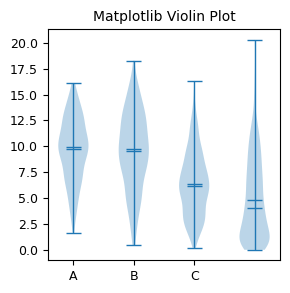

In [500]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = [DF.s10[open_&dir_conds(DF, 'wind')], 
        DF.si_km[open_&dir_conds(DF, 'ice')]/1.7, 
        DF.s10[comp_&dir_conds(DF, 'wind')],
        DF.si_km[comp_&dir_conds(DF, 'ice')]/1.7]

# Create plot
fig, ax = plt.subplots(figsize=(3,3))
ax.violinplot(data, showmeans=True, showmedians=True)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['A', 'B', 'C'])
plt.title('Matplotlib Violin Plot')
plt.show()


In [484]:
DF.si_km[comp_]

2270     6.650074
2271    11.608836
2272    12.350517
2273     5.324902
2274     3.383809
          ...    
5440     5.174790
5441     4.410327
5442     1.433033
5443    12.503789
5444    10.230725
Name: si_km, Length: 2565, dtype: float64

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


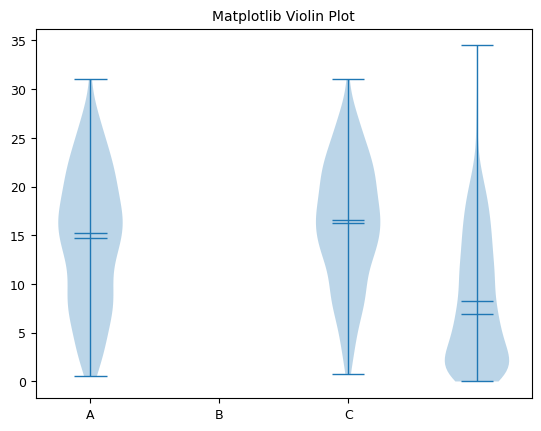

In [486]:
DF= dfb

# Sample data
data = [DF.si_km[open_], DF.si_km[comp_], 
        DF.si_km[open_&dir_conds(DF, 'ice')], DF.si_km[comp_&dir_conds(DF, 'ice')]]

# Create plot
fig, ax = plt.subplots()
ax.violinplot(data, showmeans=True, showmedians=True)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['A', 'B', 'C'])
plt.title('Matplotlib Violin Plot')
plt.show()

In [489]:
np.sum(np.isnan(DF.si_km[comp_]))

2

In [357]:
np.nanpercentile(DF[(DF.extent>0)].s10, 25)

6.223059455247467

In [ ]:
np.nanpercentile(DF[(DF.extent>0)].s10, 25)

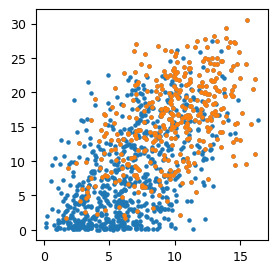

In [362]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(DF.s10[dir_conds(DF, 'wind')], DF.si_km[dir_conds(DF, 'wind')], s=5)
ax.scatter(DF.s10[dir_conds(DF, 'wind')&(DF.extent>0)], DF.si_km[dir_conds(DF, 'wind')&(DF.extent>0)], s=5)

In [369]:
np.sum(dir_conds(DF, 'wind')&((DF.extent>0)&(not_final_day==True))) / np.sum((DF.extent>0)&(not_final_day==True))

0.8657534246575342

In [373]:
np.sum(dir_conds(DF, 'wind')&(DF.extent==0)) / np.sum((DF.extent==0))

0.26003898635477585

In [394]:
east_open_events = dir_conds(DF, 'wind')&(DF.extent>0)
alon_open_events = dir_conds(DF, 'ice')&(DF.extent>0)

east_comp_events = dir_conds(DF, 'wind')&(DF.extent==0)
alon_comp_events = dir_conds(DF, 'ice')&(DF.extent==0)

In [392]:
np.nanpercentile(DF.s10[east_open_events],25)

7.431806753415982

In [393]:
np.nanpercentile(DF.si_km[alon_open_events],25)

12.018180291875913

In [401]:
np.sum(DF.si_km[alon_comp_events] > 12) / np.sum(alon_comp_events)

0.28657799274486095

In [402]:
np.sum(DF.si_km[alon_open_events] > 12) / np.sum(alon_open_events)

0.7506925207756233

In [403]:
np.sum(DF.s10[east_open_events] > 7.5) / np.sum(east_open_events)

0.745945945945946

In [404]:
np.sum(DF.s10[east_comp_events] > 7.5) / np.sum(east_comp_events)

0.3448275862068966

In [356]:
np.nanpercentile(DF[(DF.extent>0)].si_km, 30)

10.334981669275635

In [230]:
12/7.5

1.6

In [226]:
np.nanpercentile(DF[dir_conds(DF,'wind')&(DF.extent>0)].s10, 25)

7.431806753415982

In [227]:
np.nanpercentile(DF[dir_conds(DF,'ice')&(DF.extent>0)].si_km, 25)

12.018180291875913

In [182]:
np.nanmedian(DF[(dir_conds(DF,'wind')&((DF.s10>6.5)&(DF.s10<7.5)))].si_km)

10.88108242677978

In [106]:
help(SAVE)

Help on function SAVE in module __main__:

SAVE(fig, filename)



In [97]:
10.5/7

1.5

In [98]:
20*1.5

30.0

In [88]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'esei', 'ese10', 'si_km', 'e10', 'a10_r', 'ai_r',
       'centermass_direction_r', 'max_length_direction_r', 'up', 'vp', 'ta_wi',
       'ta_ip', 'ta_wp'],
      dtype='object')

In [89]:
DF.day_before_event!=-1

2269    True
2270    True
2271    True
2272    True
2273    True
        ... 
5440    True
5441    True
5442    True
5443    True
5444    True
Name: day_before_event, Length: 3176, dtype: bool

In [75]:
np.nanpercentile(DF.s10[dir_conds(DF, 'wind') & (DF.extent>0)], 20)

7.000063475218989

In [76]:
np.nanpercentile(DF.si_km[dir_conds(DF, 'ice') & (DF.extent>0)], 20)

10.410253013183217

In [81]:
np.nanpercentile(DF.s10[dir_conds(DF, 'wind') & (DF.extent==0)], 60)

6.999765512526426

In [ ]:
np.nanpercentile(DF.s10[dir_conds(DF, 'wind') & (DF.extent==0)], 60)

In [182]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'esei', 'ese10', 'si_km', 'e10', 'a10_r', 'ai_r',
       'centermass_direction_r', 'max_length_direction_r', 'up', 'vp', 'ta_wi',
       'ta_ip', 'ta_wp'],
      dtype='object')

(array([232., 167.,  43.,   3.,   6.,   2.,   2.,   0.,   1.,   3.]),
 array([  0.        ,  21.62105315,  43.24210629,  64.86315944,
         86.48421259, 108.10526574, 129.72631888, 151.34737203,
        172.96842518, 194.58947833, 216.21053147]),
 <BarContainer object of 10 artists>)

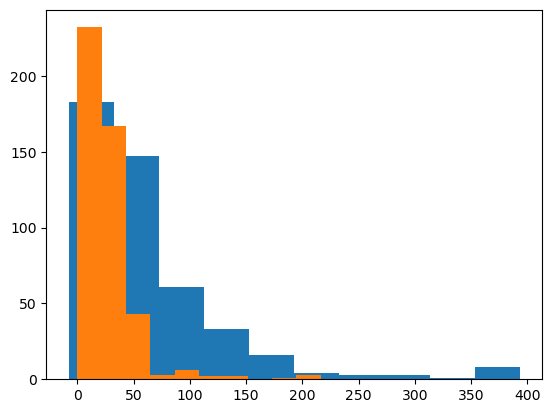

In [187]:
plt.hist(DF['length_145max'][open_])
plt.hist(DF['width'][open_])

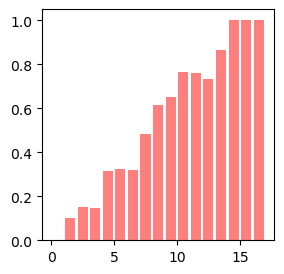

In [330]:
fig, ax = plt.subplots(figsize=(3,3))


bin_edges = np.arange(0,18,1)
bin_width = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + bin_width/2

# ax2 = ax.twinx()

DF = dfr

for cnt in bin_centers:
    
    in_bin = (DF.s10 >= cnt-bin_width/2) & (DF.s10 < cnt+bin_width/2)
    gt_bin = (DF.s10 >= cnt-bin_width/2)
    lt_bin = (DF.s10 < cnt-bin_width/2)

    wind_cond = (in_bin & (dir_conds(DF, 'wind'))) & (DF.year>=2016)
    
#     ax.bar(cnt, np.sum(wind_cond)/len(DF[(DF.year<2016)&(dir_conds(DF, 'wind'))]), color='lightgray')
#     wind_cond = (in_bin & (dir_conds(DF, 'wind'))) & (DF.year>=2016)
#     ax.bar(cnt, np.sum(wind_cond)/len(DF[(DF.year>=2016)&(dir_conds(DF, 'wind'))]), color='r', alpha=0.5)
    
    ax.bar(cnt, np.sum(wind_cond&(DF.extent>0))/np.sum(wind_cond), color='r', alpha=0.5)
    
#     wind_cond = (in_bin & (dir_conds(DF, 'ice'))) & (DF.year>=2016)
#     ax.bar(cnt, np.sum(wind_cond&(DF.extent>0))/np.sum(wind_cond), color='b', alpha=0.5, zorder=-1)
    
#     ax.bar(cnt, np.sum(wind_cond&(DF.extent==0))/np.sum(wind_cond), color='r', alpha=0.5)
    
# ax.set_ylim(0.2,1)  

In [238]:
np.sum(dfr.event_length > 1)

468

In [213]:
np.sum((speed_conds(DF, 'wind') &speed_conds(DF, 'ice') )& (open_)) / np.sum(open_)

0.6427015250544662

In [236]:
np.sum((speed_conds(DF, 'wind') &speed_conds(DF, 'ice') )& (comp_)) / np.sum(comp_)

0.1337231968810916

In [207]:
np.sum(dir_conds(DF, 'wind') & (comp_)) / np.sum(comp_)

0.26003898635477585

In [208]:
np.sum(dir_conds(DF, 'ice') & (comp_)) / np.sum(comp_)

0.3224171539961014

In [225]:
np.nanmean(DF[dir_conds(DF, 'wind') & (open_)].s10)/np.nanmean(DF[dir_conds(DF, 'wind') & (comp_)].s10)

1.5156143481228357

In [235]:
np.nanmean(DF[dir_conds(DF, 'ice') & (comp_)].si_km)

8.244899101817778

In [996]:
dir_event = dir_conds(DF, 'wind') & dir_conds(DF, 'ice')
speed_event = speed_conds(DF, 'wind') & speed_conds(DF, 'ice')

print(np.sum(cond&dir_event)/np.sum(dir_event))
print(np.sum(cond&(dir_event&speed_event))/np.sum(dir_event&speed_event))

print()
print(np.sum(cond&dir_event)/np.sum(cond))
print(np.sum(cond&(dir_event&speed_event))/np.sum(cond))

0.31496062992125984
0.4896694214876033

0.8588957055214724
0.7269938650306749


In [1876]:
1/(6.5*units('m/s') / (10*units('km/day').to('m/s')))

<Quantity(0.0178062678, 'dimensionless')>

In [1854]:
np.sum(dir_conds(DF[cond], 'ice'))/np.sum(cond)

0.3219741480611046

In [1855]:
np.sum(dir_conds(DF[cond], 'ice')+dir_conds(DF[cond], 'wind'))/np.sum(cond)

0.40775558166862513

In [361]:
DF = dfb

In [366]:
np.nanpercentile(DF.s10[DF.extent>0], 25)

6.223059455247467

In [367]:
np.nanpercentile(DF.si_km[DF.extent>0], 25)

9.065701407080223

In [1851]:
np.nanpercentile(DF[cond][dir_conds(DF[cond], 'ice')+dir_conds(DF[cond], 'wind')].s10, 50)

9.695502569375368

In [1852]:
np.nanpercentile(DF[cond][dir_conds(DF[cond], 'ice')&dir_conds(DF[cond], 'wind')].si_km, 50)

16.734817261671825

In [1781]:
6 * (0.019290123456790122*100) * units('cm/s').to('km/day')

<Quantity(10.0, 'kilometer / day')>

In [1768]:
1*(0.0192901234*100)

1.92901234

In [1777]:
35 / (0.0192901234*100)

19.444444444444446

In [1764]:
10*units('km/day').to('m/s') / 6

<Quantity(0.0192901235, 'meter / second')>

In [1782]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [1783]:
np.sum(speed_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7622080679405521

In [813]:
np.sum(dir_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7770700636942676

In [812]:
np.sum(dir_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7961783439490446

In [702]:
0.0178 * 1 * units('m/s').to('km/day')

<Quantity(1.53792, 'kilometer / day')>

In [742]:
26*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(16.9059509, 'meter / second')>

In [ ]:
30*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

In [699]:
30.75*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(19.9945381, 'meter / second')>

In [691]:
10*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(6.50228881, 'meter / second')>

In [721]:
np.sum(speed_conds(DF[DF.extent==0], 'ice'))/np.sum(DF.extent==0)

0.18527222875048963

In [723]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [665]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [666]:
color1

[0.19607843137254902, 0.45098039215686275, 1.0]

In [168]:
0.02*20*units('m/s').to('cm/s').to('km/day')

<Quantity(34.56, 'kilometer / day')>

In [135]:
0.02*1*units('m/s').to('cm/s').to('km/day')

<Quantity(1.728, 'kilometer / day')>

NameError: name 'c2' is not defined

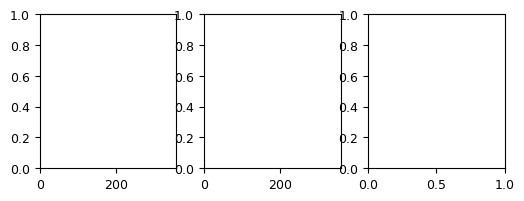

In [439]:

# create plot
fig, AXS = plt.subplots(1,3, figsize=(6,2), subplot_kw={'projection': None})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
# fig.delaxes(axs[0])
# fig.delaxes(axs[1])
# fig.delaxes(axs[2])
# axs[0] = fig.add_subplot(1,5, 1, projection='polar')
# axs[1] = fig.add_subplot(1,5, 2, projection='polar')
# axs[2] = fig.add_subplot(1,5, 3, projection='polar')

# for ax in [axs[0]]:
#     ax.set_theta_zero_location("N")
#     ax.set_theta_direction(-1)
#     ax.grid(zorder=-1)






#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============


for ax in [axs[0], axs[1]]:
    ax.set_xlim(0,360)

ccolor = c2
bcolor = 'red'

bins = np.arange(0,361,10)
comp_ = (DF.extent==0)
# open_ = (DF.extent>0)&(not_last_day)
open_ = (DF.extent>0)#&(not_last_day)

# open_ = DF.day_before_event == -1
# open_ = ((DF.extent>0)&(not_last_day)) + (DF.day_before_event == -1)
# open_strict = (open_)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)
#  'centermass_direction_r'
for ax, group, cond, color, alpha in zip([axs[0], axs[0], ], 
                            ['a10_r', 'a10_r',], [open_ , comp_], 
                            ['r', 'lightcoral', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.25, color=color, zorder=3)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1], ], 
                            ['ai_r', 'ai_r',], [open_ , comp_], 
                            ['royalblue', 'skyblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
for ax, group, cond, color, scale in zip([axs[2], ], 
                            ['centermass_direction_r', ], [open_ ], 
                            ['r', ], [1,]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
for ax in axs:
    ax.set_xlim(0,360)
    ax.set_xticks([0,90,180,270,360])
    ax.set_ylim(0,35)
    ax.yaxis.tick_right()
    
for ax in axs[:-1]:
    ax.set_yticklabels([])

    
    
ax = axs[0]
ax.axvline((90-173)+360, c='r', ls='dotted')

ax = axs[1]
ax.axvline((90-165)+360)

ax = axs[2]
ax.axvline((90-145)+360)

# axs[0].set_ylim(0,20)
# axs[1].set_ylim(0,15)
# axs[2].set_ylim(0,20)
# for ax, R in zip([axs[0], axs[1], axs[2]], [5,3,5]):
#     th = (90+15)*np.pi/180
#     ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
#     ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
#     ax.text((90+15)*np.pi/180, R, 'coast', rotation = -15, va='top')
    
    
AX = fig.add_axes([-0.45, 0.15, 0.75, 0.75], projection='polar') # inset polar axes
ax = AX
ax.set_ylim(0,10)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_xticks(np.array([0,90,180,270])*(np.pi/180))


th = (90+15)*np.pi/180
ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
ax.text((90+15)*np.pi/180, 5, 'coast', rotation = -15, va='top', ha='center')

th = (90-173+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='r', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='r', ls='dashed', lw=1, zorder=100)
# ax.text((90+173)*np.pi/180, 0, 'coast', rotation = -15, va='top', ha='center')

th = (90-161+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='royalblue', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='royalblue', ls='dashed', lw=1, zorder=100)

th = (90-143+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='gray', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='gray', ls='dashed', lw=1, zorder=100)

In [2343]:
print(vectors.vector_angle(np.nanmean(DF['u10'][open_]), np.nanmean(DF['v10'][open_])))
print(vectors.vector_angle(np.nanmean(DF['ui'][open_]), np.nanmean(DF['vi'][open_])))
print(vectors.vector_angle(np.nanmean(DF['up'][open_]), np.nanmean(DF['vp'][open_])))

173.3737593024387 degree
161.75337988688685 degree
143.01459107603304 degree


In [1625]:
DF.up[COND]

2269   -38.204756
2278   -21.594618
2279   -16.129223
2290   -13.010949
2291   -25.661554
          ...    
5407     5.895805
5413     0.890385
5414   -30.744152
5415   -30.194390
5416   -17.019778
Name: up, Length: 471, dtype: float64

In [ ]:
df

In [353]:
DF = dfb

COND = DF.extent>0
A10 = vectors.vector_angle(np.nanmean(DF.u10[COND]), np.nanmean(DF.v10[COND]))
Ai = vectors.vector_angle(np.nanmean(DF.ui[COND]), np.nanmean(DF.vi[COND]))
Ap = vectors.vector_angle(np.nanmean(DF.up[COND]), np.nanmean(DF.vp[COND]))

print(A10)
print(Ai)
print(Ap)

173.3737593024387 degree
161.75337988688685 degree
143.01459107603304 degree


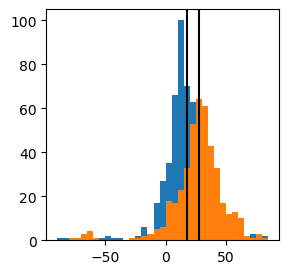

In [354]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(DF['ta_wi'][open_], bins=np.arange(-90,90,5))
plt.hist(DF['ta_wp'][open_], bins=np.arange(-90,90,5))
plt.axvline(18, c='k')
plt.axvline(28, c='k')

In [2464]:
np.nanmedian(DF['ta_ip'][open_])

18.310160999317887

In [2463]:
np.nanmedian(DF['ta_wp'][open_])

28.500028176940397

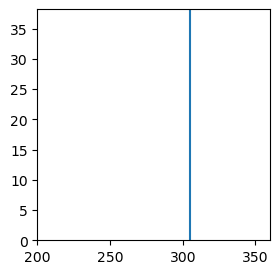

In [1422]:

#============
# DF = df[(df.year>=1987)&(df.year<2026)]
DF = dfb
# DF = df[(df.year>=2016)&(df.year<2024)]
# DF = df[(df.year>=2003)&(df.year<2016)]
#============

fig, ax = plt.subplots(figsize=(3,3))
x = DF[f'centermass_direction_r'][(DF.extent>0)]
h = plotter.quick_hist(x, bin_edges = bins)


theta = h['centers']
width = h['w']
ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)
    

x = DF[f'max_length_direction_r'][(DF.extent>0)]
h = plotter.quick_hist(x, bin_edges = bins)


theta = h['centers']
width = h['w']
ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color='r', zorder=-1)
ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color='r',lw=1, zorder=-1)
    
    
ax.set_xlim(200,360)
ax.axvline((90-145)+360)

In [936]:
(90-165)+360

285

In [937]:
(90-145)+360

305

In [938]:
np.nanmedian(DF[f'max_length_direction_r'][(DF.extent>0)])

301.52934204516964

In [939]:
np.nanmedian(DF[f'centermass_direction_r'][(DF.extent>0)])

305.7704628259503

In [1203]:
10*units('km/day').to('m/s')/0.02

<Quantity(5.78703704, 'meter / second')>

In [1204]:
np.linspace(8,6, len(years))

array([8.        , 7.90909091, 7.81818182, 7.72727273, 7.63636364,
       7.54545455, 7.45454545, 7.36363636, 7.27272727, 7.18181818,
       7.09090909, 7.        , 6.90909091, 6.81818182, 6.72727273,
       6.63636364, 6.54545455, 6.45454545, 6.36363636, 6.27272727,
       6.18181818, 6.09090909, 6.        ])

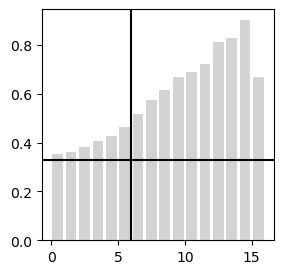

In [1274]:

# likelihoods = np.array([])

fig, ax = plt.subplots(figsize=(3,3))

# all_wind_dir = np.sum(wind_dir_cond)
# all_ice_dir = np.sum(ice_dir_cond)

cat = 'wind'
scat = 's10'

# cat = 'ice'
# scat = 'si_km'

all_dir = np.sum(dir_conds(DF, cat))

for bb in range(len(speed_bins[cat])-1):
    
    bmin = speed_bins[cat][bb]
    bmax = speed_bins[cat][bb+1]
    bmid = (bmax+bmin)/2
    
    not_last_day = (DF.final_day == False)
    not_last_day[DF.single_day == True] = True

    speed_range = (DF[scat] > bmin) & (DF[scat] > bmax)
#     speed_range = (DF[scat] < bmax)


    COND = speed_range & (dir_conds(DF, cat)==True)
    total_counts = np.sum(COND)
    open_counts = np.sum((DF['extent'][COND].values > 0))#&not_last_day[COND])
#     db_counts = np.sum(DF['day_before_event'][COND].values == -1)
    
#     plt.bar(bmid, (db_counts+open_counts)/total_counts, color='gray', width = 0.8*(bmax-bmin))
    plt.bar(bmid, (open_counts)/total_counts, color='lightgray', width = 0.8*(bmax-bmin))
    
    
#     plt.bar(bmid, 10*(total_counts/all_dir), bottom = 1, color='k', alpha=0.1, width = 0.8*(bmax-bmin))
    
plt.axvline(6, c='k')
plt.axhline(0.33, c='k')

In [1690]:
0.02 * 6 * units('m/s').to('km/day')

<Quantity(10.368, 'kilometer / day')>

In [1206]:

np.nanpercentile(DF.si[(DF['extent'] == 0)], 75)

9.048566991439179

In [1207]:
np.nanpercentile(DF.si[(DF['extent'] > 0)], 30)

11.697253499171095

In [1208]:
np.nanpercentile(DF.s10[(DF['extent'] > 0)], 30)

6.952249333466214

In [521]:
years = np.arange(2003,2026)

#================
DF = dfr
#================


months = [12,1,2,3,4]
monthly = {}
monthly['pol_cts_no12'] = {}
monthly['pol_cts_no122425'] = {}
monthly['win_cts'] = {}
monthly['win_cts_no12'] = {}
monthly['win_cts_no2425'] = {}
monthly['win_cts_no122425'] = {}
monthly['ice_cts_no2425'] = {}
monthly['ice_cts_no122425'] = {}
monthly['tot_cts'] = {}
monthly['tot_cts_no12'] = {}
monthly['tot_cts_no2425'] = {}
monthly['tot_cts_no122425'] = {}

for key in monthly:
    for month in months:
        monthly[key][month] = 0

        
years = np.arange(2003,2026)
annual = {}
annual['pol_cts'] = {}
annual['win_cts'] = {}
annual['ice_cts'] = {}

for key in annual:
    for year in years:
        annual[key][year] = 0



pol_counts = np.array([])
win_counts = np.array([])
ice_counts = np.array([])

wind_factors = {}
wind_factors[25] = np.array([])
wind_factors[50] = np.array([])
wind_factors[75] = np.array([])

wf_match_years = np.array([])
years_match_wf = np.array([])

wind_speeds = {}
wind_speeds[25] = np.array([])
wind_speeds[50] = np.array([])
wind_speeds[75] = np.array([])

ice_speeds = {}
ice_speeds[25] = np.array([])
ice_speeds[50] = np.array([])
ice_speeds[75] = np.array([])

air_temps = {}
air_temps[25] = np.array([])
air_temps[50] = np.array([])
air_temps[75] = np.array([])

for year in years:
    
    
    year_cond = (DF.year == year)
    
    
    
    # EVENT COUNTS
    #------------------------------
    
    # polynyas
    #----------
    
    pol_cond = (DF.extent > 0)
    
    if year in [2012]:
        annual['pol_cts'][year] += np.nan
        pol_counts= np.append(pol_counts, np.nan)
    
    else:
        num_pol = np.sum(pol_cond&year_cond)
        annual['pol_cts'][year] += num_pol
        
        pol_counts= np.append(pol_counts, num_pol)

    # save monthly counts
    for month in months:
        month_cond = (DF.month == month)
        
        if year not in [2012]:
            monthly['pol_cts_no12'][month] += np.sum((year_cond&month_cond)&pol_cond)
            monthly['tot_cts_no12'][month] += np.sum(year_cond&month_cond)

        if year not in [2024,2025]: 
            monthly['pol_cts_no122425'][month] += np.sum((year_cond&month_cond)&pol_cond)
            monthly['tot_cts_no122425'][month] += np.sum(year_cond&month_cond)
    
    # winds
    #----------
    
    wind_cond = (dir_conds(DF, 'wind'))&(DF['s10'] > 7.5)
    num_win = len(DF[year_cond&wind_cond])
    win_counts= np.append(win_counts, num_win)
    
    
    annual['win_cts'][year] += np.sum(year_cond&wind_cond)
    
#     if year in [2012]:
#         annual['win_cts_no12'][year] += np.nan
#     else:
#         annual['win_cts_no12'][year] += np.sum(year_cond&wind_cond)
#         if year in [2024, 2025]:
#             annual['win_cts_no122425'][year] += np.nan
#         else:
#             annual['win_cts_no122425'][year] += np.sum(year_cond&wind_cond)
        
        
    for month in months:
        
        month_cond = (DF.month == month)
        monthly['win_cts'][month] += np.sum((year_cond&month_cond)&wind_cond)
        monthly['tot_cts'][month] += np.sum(year_cond&month_cond)

        if year not in [2012]:
            monthly['win_cts_no12'][month] += np.sum((year_cond&month_cond)&wind_cond)
        if year not in [2024, 2025]:
            monthly['tot_cts_no2425'][month] += np.sum((year_cond&month_cond))
            monthly['win_cts_no2425'][month] += np.sum((year_cond&month_cond)&wind_cond)
        if year not in [2012, 2024,2025]: 
            monthly['win_cts_no122425'][month] += np.sum((year_cond&month_cond)&wind_cond)

    # ice
    #----------
    
    ice_cond = (dir_conds(DF, 'ice'))&(DF['si_km'] > 12)
    
    annual['ice_cts'][year] += np.sum(year_cond&ice_cond)
    
    for month in months:
        
        month_cond = (DF.month == month)
        if year not in [2024,2025]:
            monthly['ice_cts_no2425'][month] += np.sum((year_cond&month_cond)&ice_cond)
        if year not in [2012, 2024, 2025]:
            monthly['ice_cts_no122425'][month] += np.sum((year_cond&month_cond)&ice_cond)
                
                
    
    if year > 2023:
        ice_counts= np.append(ice_counts, np.nan)
    else:
        num_ice = len(DF[(DF.year == year)&((dir_conds(DF, 'ice'))&(DF['si_km'] > 12))])
        ice_counts= np.append(ice_counts, num_ice)
    
#     wind_dir_cond
    all_ws = DF.s10[(DF.year == year)&(DF.extent>0)]
    for key in ice_speeds.keys():
        wind_speeds[key] = np.append(wind_speeds[key], np.nanpercentile(all_ws, key))
        
        
    all_t2m = DF.t2m[(DF.year == year)&(DF.extent>0)]
    for key in ice_speeds.keys():
        air_temps[key] = np.append(air_temps[key], np.nanpercentile(all_t2m, key))
            
    # ice speeds
    if year > 2023:
        for key in ice_speeds.keys():
            ice_speeds[key] = np.append(ice_speeds[key],  np.nan)
    else:
        all_is = DF.si[(DF.year == year)&(DF.extent>0)]
        for key in ice_speeds.keys():
            ice_speeds[key] = np.append(ice_speeds[key], np.nanpercentile(all_is, key))

    # wind factors
    if year > 2023:
        for key in wind_factors.keys():
            wind_factors[key] = np.append(wind_factors[key],  np.nan)
    else:
        all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
        
        wf_match_years = np.append(wf_match_years, all_wf)
        years_match_wf = np.append(years_match_wf, np.full(len(all_wf), year))
        
        for key in ice_speeds.keys():
            wind_factors[key] = np.append(wind_factors[key], np.nanpercentile(all_wf, key))


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [510]:
DF = dfb

In [514]:
np.nanpercentile(DF.s10[(DF.extent>0)&(dir_conds(DF, 'wind'))], 25)

7.431806753415982

In [515]:
np.nanpercentile(DF.si_km[(DF.extent>0)&(dir_conds(DF, 'ice'))], 25)

12.018180291875913

In [513]:
np.nanpercentile(DF.si_km[DF.extent>0], 20)

7.871787705925337

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/3924069139.py:50: RuntimeWarning: All-NaN slice encountered
  ax.scatter(year, np.nanmedian(yeardat), c='lightgray')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/3924069139.py:53: RuntimeWarning: All-NaN slice encountered
  ax.scatter(year, np.nanmedian(yeardat), c='r')


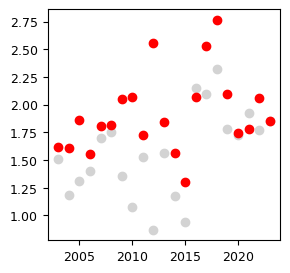

In [522]:
annual['win_cts_no12'] = annual['win_cts'].copy()
annual['win_cts_no12'][2012] = np.nan

annual['win_cts_no2425'] = annual['win_cts'].copy()
annual['win_cts_no2425'][2024] = np.nan
annual['win_cts_no2425'][2025] = np.nan

annual['win_cts_no122425'] = annual['win_cts'].copy()
annual['win_cts_no122425'][2012] = np.nan
annual['win_cts_no122425'][2024] = np.nan
annual['win_cts_no122425'][2025] = np.nan

annual['ice_cts_no12'] = annual['ice_cts'].copy()
annual['ice_cts_no12'][2012] = np.nan

annual['ice_cts_no2425'] = annual['ice_cts'].copy()
annual['ice_cts_no2425'][2024] = np.nan
annual['ice_cts_no2425'][2025] = np.nan

annual['ice_cts_no122425'] = annual['ice_cts'].copy()
annual['ice_cts_no122425'][2012] = np.nan
annual['ice_cts_no122425'][2024] = np.nan
annual['ice_cts_no122425'][2025] = np.nan

all_ice_cts = np.array([annual['ice_cts_no2425'][key] for key in annual['ice_cts_no2425'].keys()])
all_pol_cts = np.array([annual['pol_cts'][key] for key in annual['pol_cts'].keys()])
# all_win_cts = np.array([annual['win_cts_no122425'][key] for key in annual['win_cts_no122425'].keys()])
all_win_cts = np.array([annual['win_cts'][key] for key in annual['win_cts'].keys()])

years_no12 = np.append(np.arange(2003,2012), np.arange(2013,2026))
years_no122425 = np.append(np.arange(2003,2012), np.arange(2013,2024))


include_months = (df.month ==1)
include_months[(df.month ==12)] = True

# include_months = (df.month ==4)
# include_months[(df.month ==3)] = True
# include_months[(df.month ==2)] = True


win_ev = dir_conds(df, 'wind') & (df['s10'] > 3)

fig, ax = plt.subplots(figsize=(3,3))

for year in np.arange(2003,2025):
    
    yeardat = (df.si/df.s10)[win_ev&(df.year==year)]

    ax.scatter(year, np.nanmedian(yeardat), c='lightgray')
    
    yeardat = (df.si/df.s10)[(win_ev&(df.year==year))&(include_months)]
    ax.scatter(year, np.nanmedian(yeardat), c='r')


In [523]:
0.904**2

0.817216

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


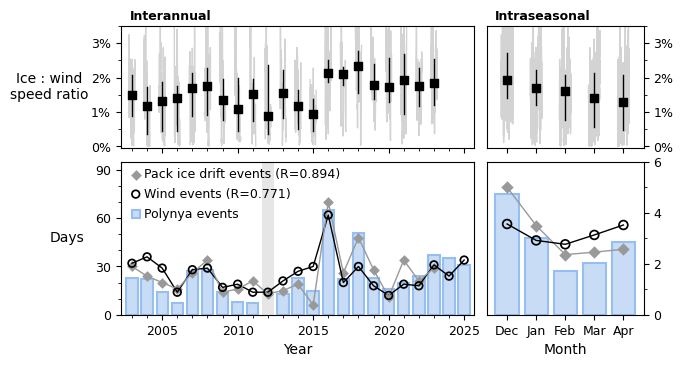

In [524]:
fig, AXS = plt.subplots(2,2,figsize=(6.75,3.75), gridspec_kw={'width_ratios':[2.25,1], 'height_ratios':[1,1.25]})

axs = AXS.ravel()

years = np.arange(2003,2026)
months = [12,1,2,3,4]

# total events per year
# annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


# mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'P', 'zorder':10, 's':23}
# mar1_kw = {'edgecolor': 'k', 'facecolor':'k', 'lw':1, 'marker':'D', 'zorder':10, 's':30}
# mar2_kw = {'edgecolor': [0.35,0.35,0.35], 'facecolor':'lightgray', 'lw':1.5, 'marker':'o', 's':35}

C = [0.6,0.6,0.6]

mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'o', 'zorder':10, 's':30}
mar2_kw = {'edgecolor': C, 'facecolor':C, 'lw':0, 'marker':'D', 's':30}

mar1_kw_L = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'o', 'zorder':10, 's':40}
mar2_kw_L = {'edgecolor': C, 'facecolor':C, 'lw':0, 'marker':'D', 's':40}

# mar2_kw = {'edgecolor': 'None', 'facecolor':[0.65,0.65,0.65], 'lw':1.5, 'marker':'x', 's':30}
# cmocean.cm.ice(0.7)
# mar3_kw = {'facecolor':[160/255,220/255,239/255],'edgecolor':cmocean.cm.ice(0.7), 
#            'lw':1.5, 'marker':'s', 's':40}

mar3_kw = {'facecolor':[200/255,220/255,245/255],'edgecolor':[150/255,190/255,240/255], 
           'lw':1.5, 'marker':'s', 's':40}
# bar_kw = {'facecolor':[166/255,205/255,255/255],'edgecolor':[130/255,175/255,235/255], 'lw':0, "alpha":1}

bar_kw = {'facecolor':[200/255,220/255,245/255],'edgecolor':[150/255,190/255,240/255], 'lw':1.5, "alpha":1}

# bar_kw = {'facecolor':[160/255,220/255,239/255],'edgecolor':cmocean.cm.ice(0.7), 'lw':1.5, "alpha":1}
# bar_kw = {'color':'lightcoral', "alpha":1}

ax = axs[2]

for yy, year in enumerate(years):

    
    ax.bar(year, annual['pol_cts'][year], width=0.75, **bar_kw)
    
    
    ax.scatter(year, annual['win_cts'][year], **mar1_kw)
    
    
    ax.scatter(year, annual['ice_cts_no2425'][year], **mar2_kw)

ax.plot(years, [annual['win_cts'][year] for year in years], c='k', lw=1)

ax.plot(years, [annual['ice_cts_no2425'][year] for year in years], c=C, lw=1)
        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color=[0.9,0.9,0.9], zorder=-11)
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax = axs[3]

for mm, month in enumerate(months):
    month
#     monthly['pol_cts'] = {}
# monthly['win_cts'] = {}
# monthly['ice_cts'] = {}
# monthly['tot_cts'] = {}
# monthly['tot_cts_no12'] = {}

#     ax.bar(mm, monthly['pol_cts_no12'][month]/monthly['tot_cts_no12'][month], alpha=0.5, color='b')


    total_days = monthly['tot_cts_no122425'][month]
    
    ax.bar(mm, len(years_no122425)*monthly['pol_cts_no122425'][month]/total_days, **bar_kw)
    ax.scatter(mm, len(years_no122425)*monthly['win_cts_no122425'][month]/total_days, **mar1_kw_L)
    ax.scatter(mm, len(years_no122425)*monthly['ice_cts_no122425'][month]/total_days, **mar2_kw_L)

ax.plot(np.arange(len(months)), [len(years_no122425)*monthly['ice_cts_no122425'][month]/monthly['tot_cts_no122425'][month] for month in months], c=C, lw=1)  
ax.plot(np.arange(len(months)), [len(years_no122425)*monthly['win_cts_no122425'][month]/monthly['tot_cts_no122425'][month] for month in months], c='k', lw=1)      
    
    
# ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,6)

plt.subplots_adjust(wspace=0.1)


x = all_ice_cts
y = all_pol_cts
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_win_cts
y = all_pol_cts
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[2]
ax.scatter(2003.25,75, **mar1_kw)
ax.text(2003.25,75, f'  Wind events (R={Rw:.3f})', va='center')

ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack ice drift events (R={Rp:.3f})', va='center')

ax.scatter(2003.25,62.5, **mar3_kw)
ax.text(2003.25,62.5, f'  Polynya events', va='center')



ax = axs[0]
DF = dfb
for year in years:
    all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
#     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    
    bf = 0.2
    ax.plot(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray',  zorder=-1)
#     ax.scatter(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray', s=5, zorder=-1)
    ax.scatter(year, np.nanmedian(all_wf), marker='s', c='k')
    ax.plot([year,year], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
#     print(year, np.nanmedian(all_wf))
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([])
ax.set_ylabel('Ice : wind\nspeed ratio', rotation=0, labelpad=30, va='center')
    
ax = axs[1]
# ax.set_ylim(-0.1,4.5)
DF = df[((df.year>=2003)&(df.year<=2023))&(df.year!=2012)]
for mm, month in enumerate(months):
    
    all_wf = (DF.si/DF.s10)[((DF.month == month)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
#     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    bf = 0.2
    ax.plot(np.linspace(mm-bf, mm+bf,len(all_wf)), all_wf, c='lightgray', zorder=-1)
    ax.scatter(mm, np.nanmedian(all_wf), marker='s', c='k')
    ax.plot([mm,mm], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
    
ax.set_xticks(range(len(months)))
ax.set_xticklabels([])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


# ax.text(0.95, 1.05, 'Years\n2003-2011,\n2013-2023', 
#         weight='bold', size=9,
#         ha='right', va='bottom', clip_on=False, transform=ax.transAxes)

# ax.scatter(years, wind_factors[50])

for ax in axs[:-2]:
    ax.set_ylim(-0.1,5)
for ax in AXS[:,1]:
    ax.set_xlim(-0.7,4.7)
for ax in AXS[:,0]:
    ax.set_xlim(2002.25,2025.65)
    
def percent_format(x, pos):
    return f"{x:.0f}%" # Formats as percentage with 0 decimal places

for ax in AXS[0,:]:   
    ax.set_ylim(-0.05,3.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_format))

plt.subplots_adjust(hspace=0.1, wspace=0.05)

# for aa, ax in enumerate(axs):
#     ax.text(0.975, 0.965, f'{chr(97+aa)}', weight='bold', ha='right', va='top', transform=ax.transAxes)

axs[0].text(0.025,1.05, 'Interannual', weight='bold', clip_on=False, transform = axs[0].transAxes)
axs[1].text(0.05,1.05, 'Intraseasonal', weight='bold', clip_on=False, transform = axs[1].transAxes)


# fig.savefig('../figures/results/Fig05b_ice_too.png', dpi=400, bbox_inches='tight', pad_inches=0)

SAVE(fig, '../figures/results/counts_time/Fig05.png')

In [606]:
0.02*7.5*units('m/s').to('km/day')

<Quantity(12.96, 'kilometer / day')>

In [693]:
DF = dfr
wev = (dir_conds(DF,'wind')) & (DF.year!=2012)
iev = (dir_conds(DF,'ice')) & (DF.year!=2012)

# iev = ( (DF.si_km>13)) & (DF.year!=2012)

(5.0, 15.0)

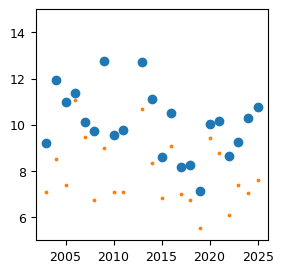

In [732]:

# Sample data
data = [DF.s10[(wev&(DF.extent>0))&(DF.year==year)].values for year in years[years!=2012]]

# Create plot
fig, ax = plt.subplots(figsize=(3,3))
# ax.violinplot(data,positions=years[years!=2012], showextrema=False, showmeans=True)

ax.scatter(years[years!=2012], [np.nanmedian(DAT) for DAT in data])
ax.scatter(years[years!=2012], [np.nanpercentile(DAT, 25) for DAT in data], s=3)
# ax.scatter(years[years!=2012], [np.nanpercentile(DAT, 75) for DAT in data], s=3)

# showmeans=True, 
# ax.set_xticks(years[years!=2012])
# ax.set_xticklabels(['A', 'B', 'C'])
ax.set_ylim(5,15)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/986257033.py:12: RuntimeWarning: Mean of empty slice
  ax.scatter(year, np.nanmean(DF.s10[open_ev&wind_ev]), c='k')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/986257033.py:14: RuntimeWarning: Mean of empty slice
  ax.scatter(year, np.nanmean(DF.s10[(open_ev==False)&wind_ev]), c='lightgray')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/986257033.py:16: RuntimeWarning: Mean of empty slice
  ax.scatter(year, np.nanmean(DF.s10[wind_ev]), c='lightblue')


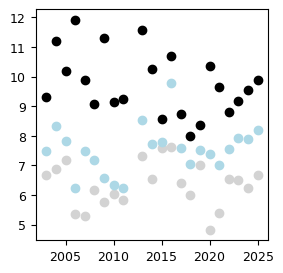

In [691]:
fig, ax = plt.subplots(figsize=(3,3))

wind_poly_ratios = np.array([])
ice_poly_ratios = np.array([])

for year in years:
    
    wind_ev = wev & (DF.year==year)
    open_ev = (DF.extent>0)

    
    ax.scatter(year, np.nanmean(DF.s10[open_ev&wind_ev]), c='k')
    
    ax.scatter(year, np.nanmean(DF.s10[(open_ev==False)&wind_ev]), c='lightgray')
    
    ax.scatter(year, np.nanmean(DF.s10[wind_ev]), c='lightblue')
    

In [681]:
DF = dfr
wev = (dir_conds(DF,'wind') & (DF.s10>7.5)) & (DF.year!=2012)
iev = (dir_conds(DF,'ice') & (DF.si_km>12)) & (DF.year!=2012)


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/992990939.py:12: RuntimeWarning: invalid value encountered in scalar divide
  event_ratio = np.sum(open_ev&wind_ev)/np.sum(wind_ev)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25941/992990939.py:20: RuntimeWarning: invalid value encountered in scalar divide
  event_ratio = np.sum(open_ev&iced_ev)/np.sum(iced_ev)


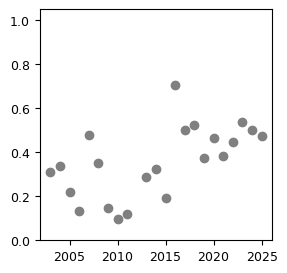

In [685]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_ylim(0,1.05)

wind_poly_ratios = np.array([])
ice_poly_ratios = np.array([])

for year in years:
    
    wind_ev = wev & (DF.year==year)
    open_ev = (DF.extent>0) #+ (DF.day_before_event==-1) 
    
    event_ratio = np.sum(open_ev&wind_ev)/np.sum(wind_ev)
    
    wind_poly_ratios = np.append(wind_poly_ratios, event_ratio)
    ax.scatter(year, event_ratio, c='gray')
    
    
    iced_ev = iev & (DF.year==year)
    
    event_ratio = np.sum(open_ev&iced_ev)/np.sum(iced_ev)
    ice_poly_ratios = np.append(ice_poly_ratios, event_ratio)
#     ax.scatter(year, event_ratio, c='gray')
    
#     open_ev = (DF.extent>0) + (DF.day_before_event==-1)

#     ax.scatter(year, np.sum(open_ev&iced_ev)/np.sum(iced_ev), c='lightgray')
    
#     ax.scatter(year, np.sum(open_ev&iced_ev)/np.sum(iced_ev), c='lightgray')

In [669]:
print(np.nanmean(ice_poly_ratios[years<2016]), np.nanmean(ice_poly_ratios[years>=2016]))

0.6024854864347898 0.7704162639253918


In [670]:
print(np.nanstd(ice_poly_ratios[years<2016]), np.nanstd(ice_poly_ratios[years>=2016]))

0.1589643075986912 0.1271571639323953


In [671]:
print(np.nanmean(wind_poly_ratios[years<2016]), np.nanmean(wind_poly_ratios[years>=2016]))

0.5365889624401887 0.8083740304271114


In [672]:
print(np.nanstd(wind_poly_ratios[years<2016]), np.nanstd(wind_poly_ratios[years>=2016]))

0.16969336225331477 0.11305166938230943


In [518]:
0.894**2

0.7992360000000001

In [519]:
0.771**2

0.594441

In [419]:
DF = dfb

In [450]:
np.sum((DF.extent>0)&((DF.s10>7)&(dir_conds(DF, 'wind'))) )/ np.sum(DF.extent>0)

0.6928104575163399

In [451]:
np.sum((DF.extent==0)&((DF.s10>7)&(dir_conds(DF, 'wind'))) )/ np.sum(DF.extent==0)

0.15048732943469786

In [449]:
np.sum((DF.extent>0)&((dir_conds(DF, 'wind'))) )/ np.sum(DF.extent>0)

0.8801742919389978

In [452]:
np.sum((DF.extent>0)&((DF.si_km>12)&(dir_conds(DF, 'ice'))) )/ np.sum(DF.extent>0)

0.6339869281045751

In [453]:
np.sum((DF.extent==0)&((DF.si_km>12)&(dir_conds(DF, 'ice'))) )/ np.sum(DF.extent==0)

0.10526315789473684

In [413]:
0.894**2

0.7992360000000001

In [311]:
DF = dfb

wind_events = dir_conds(DF, 'wind') & (DF.s10 > 7)
iced_events = dir_conds(DF, 'ice') & (DF.si_km > 11)
poly_events = (DF.extent > 0)
np.sum(wind_events&iced_events) / np.sum(iced_events)


0.6731107205623902

In [ ]:
poly_events & (DF.year!=0)

In [312]:
np.sum(poly_events)

459

In [310]:
np.sum(dir_conds(DF, 'ice')&wind_events) / np.sum(wind_events)

0.846815834767642

In [279]:
cmocean.cm.ice(0.7)

(0.41895839794568623, 0.6948701867544627, 0.796309580853497, 1.0)

In [282]:
0.79630958085*255

203.05894311675002

In [225]:
print(Rp**2)
print(Rw**2)

0.7994158487774337
0.5937511437502101


In [783]:
cum_areas = np.array([])
cum_winds = np.array([])

shoulder = (dfr.season_start_flag == True)

for year in years:
    
    cond = (dfr.year==year)#&(shoulder==False)
    
    cum_areas = np.append(cum_areas, np.sum(dfr.extent[cond]))
    
#     cond = cond & dir_conds(dfr, 'wind')
#     cum_winds = np.append(cum_winds, np.sum(dfr.s10[cond]))

#     cond = cond & dir_conds(dfr, 'wind')
#     cum_winds = np.append(cum_winds, np.sum(dfr.s10[cond]))
    cum_winds = np.append(cum_winds, np.sum(dfr.s10[cond&(dfr.u10<0)]))

#     cum_winds = np.append(cum_winds, np.sum(dfr.s10))

In [784]:
np.nanmean((all_pol_cts/all_win_cts)[years<2016])

0.5003092112555759

In [777]:
vectors.vector_angle(np.nanmean(df['up']), np.nanmean(df['vp']))

<Quantity(143.440717, 'degree')>

In [778]:

pre_2016 = np.array([])
pst_2016 = np.array([])

for year in np.arange(2003,2024):
    
    all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
    
    if year >=2016:
        pst_2016 = np.append(pst_2016, all_wf)
    else:
        pre_2016 = np.append(pre_2016, all_wf)
        
print(np.nanmean(pre_2016), np.nanmean(pst_2016))

1.3722011649482653 2.0311756897858824
